In [1]:
# Thanks to Jonathan Mulholland and Aaron Sander from Booz Allen Hamilton
# who made this code public as a part of the Kaggle Data Science Bowl 2017 contest.
# https://www.kaggle.com/c/data-science-bowl-2017/details/tutorial

import SimpleITK as sitk
import numpy as np
import os
from glob import glob
import pandas as pd

from tqdm import tqdm 

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def make_mask(center,diam,z,
              width,height, depth, 
              spacing, origin,  
              mask_width=32, mask_height=32, mask_depth=32):
    '''
Center : centers of circles px -- list of coordinates x,y,z
diam : diameters of circles px -- diameter
widthXheight : pixel dim of image
spacing = mm/px conversion rate np array x,y,z
origin = x,y,z mm np.array
z = z position of slice in world coordinates mm
    '''
    mask = np.zeros([height,width]) # 0's everywhere except nodule swapping x,y to match img
    #convert to nodule space from world coordinates

    padMask = 5
    
    # Defining the voxel range in which the nodule falls
    v_center = (center-origin)/spacing
    v_diam = int(diam/spacing[0]+padMask)
    v_xmin = np.max([0,int(v_center[0]-v_diam)-padMask])
    v_xmax = np.min([width-1,int(v_center[0]+v_diam)+padMask])
    v_ymin = np.max([0,int(v_center[1]-v_diam)-padMask]) 
    v_ymax = np.min([height-1,int(v_center[1]+v_diam)+padMask])

    v_xrange = range(v_xmin,v_xmax+1)
    v_yrange = range(v_ymin,v_ymax+1)

    # Convert back to world coordinates for distance calculation
    x_data = [x*spacing[0]+origin[0] for x in range(width)]
    y_data = [x*spacing[1]+origin[1] for x in range(height)]

    # SPHERICAL MASK
    # Fill in 1 within sphere around nodule 
#     for v_x in v_xrange:
#         for v_y in v_yrange:
#             p_x = spacing[0]*v_x + origin[0]
#             p_y = spacing[1]*v_y + origin[1]
#             if np.linalg.norm(center-np.array([p_x,p_y,z]))<=diam:
#                 mask[int((p_y-origin[1])/spacing[1]),int((p_x-origin[0])/spacing[0])] = 1.0
               
    # RECTANGULAR MASK
    for v_x in v_xrange:
        for v_y in v_yrange:
            
            p_x = spacing[0]*v_x + origin[0]
            p_y = spacing[1]*v_y + origin[1]
            
            if ((p_x >= (center[0] - mask_width)) &
                (p_x <= (center[0] + mask_width)) & 
                (p_y >= (center[1] - mask_height)) &
                (p_y <= (center[1] + mask_height))):
                
                mask[int((np.abs(p_y-origin[1]))/spacing[1]),int((np.abs(p_x-origin[0]))/spacing[0])] = 1.0
            
    
    # TODO:  The height and width seemed to be switched. 
    # This works but needs to be simplified. It's probably due to SimpleITK versus Numpy transposed indicies.
    left = np.max([0, np.abs(center[0] - origin[0]) - mask_width]).astype(int)
    right = np.min([width, np.abs(center[0] - origin[0]) + mask_width]).astype(int)
    down = np.max([0, np.abs(center[1] - origin[1]) - mask_height]).astype(int)
    up = np.min([height, np.abs(center[1] - origin[1]) + mask_height]).astype(int)
    
    top = np.min([depth, np.abs(center[2] - origin[2]) + mask_depth]).astype(int)
    bottom = np.max([0, np.abs(center[2] - origin[2]) - mask_depth]).astype(int)
    
    bbox = [[down, up], [left, right], [bottom, top]]
    
    return mask, bbox

In [3]:
############
#
# Getting list of image files
luna_path = "/media/tony/TOSHIBA EXT/luna/" 
luna_subset_path = luna_path + 'subset0/'
output_path = "./"
file_list=glob(luna_subset_path+"*.mhd")

In [4]:
#####################
#
# Helper function to get rows in data frame associated 
# with each file
def get_filename(file_list, case):
    for f in file_list:
        if case in f:
            return(f)
#
# The locations of the nodes
df_node = pd.read_csv(luna_path+"annotations.csv")
#df_node = pd.read_csv(luna_path + "candidates_with_annotations.csv")
df_node["file"] = df_node["seriesuid"].map(lambda file_name: get_filename(file_list, file_name))
df_node = df_node.dropna()  # Drops the false positives

In [10]:
df_node.head()

seriesuid      coordX      coordY  \
23  1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896... -100.567944   67.260517   
25  1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...   46.188539   48.402806   
26  1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...   36.392044   76.771663   
28  1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674...  136.434059  117.765579   
86  1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048...  145.967465 -161.197634   

        coordZ  diameter_mm                                               file  
23 -231.816619     6.440879  /media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4...  
25 -108.578632    13.596471  /media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4...  
26 -123.321911     4.343200  /media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4...  
28 -181.947817     4.681382  /media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4...  
86 -312.071347     6.378436  /media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4...

In [6]:
"""
Normalize pixel depth into Hounsfield units (HU)
This tries to get all pixels between -1000 and 400 HU.
All other HU will be masked.
Then we normalize pixel values between 0 and 1.
"""
def normalizePlanes(npzarray):
     
    maxHU = 400.
    minHU = -1000.
 
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray[npzarray>1] = 1.
    npzarray[npzarray<0] = 0.
    return npzarray

In [7]:
def normalize_img(img):
    
    '''
    Sets the MHD image to be approximately 1.0 mm voxel size
    
    https://itk.org/ITKExamples/src/Filtering/ImageGrid/ResampleAnImage/Documentation.html
    '''
    new_x_size = int(img.GetSpacing()[0]*img.GetWidth())  # Number of pixels you want for x dimension
    new_y_size = int(img.GetSpacing()[1]*img.GetHeight()) # Number of pixels you want for y dimension
    new_z_size = int(img.GetSpacing()[2]*img.GetDepth())  # Number of pixels you want for z dimesion
    new_size = [new_x_size, new_y_size, new_z_size]
    
#     new_spacing = [old_sz*old_spc/new_sz  for old_sz, old_spc, new_sz in zip(img.GetSize(), img.GetSpacing(), new_size)]

    new_spacing = [1,1,1]  # New spacing to be 1.0 x 1.0 x 1.0 mm voxel size
    interpolator_type = sitk.sitkLinear

    return sitk.Resample(img, np.array(new_size, dtype='uint32').tolist(), sitk.Transform(), interpolator_type, img.GetOrigin(), new_spacing, img.GetDirection(), 0.0, img.GetPixelIDValue())
    

  0%|          | 0/89 [00:00<?, ?it/s]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.277445975068759205899107114231.mhd


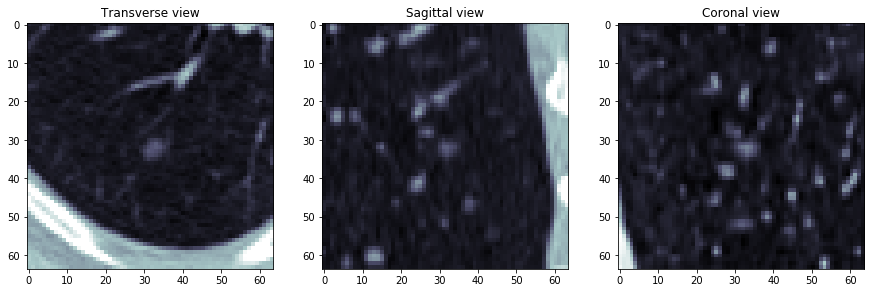

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.277445975068759205899107114231.mhd


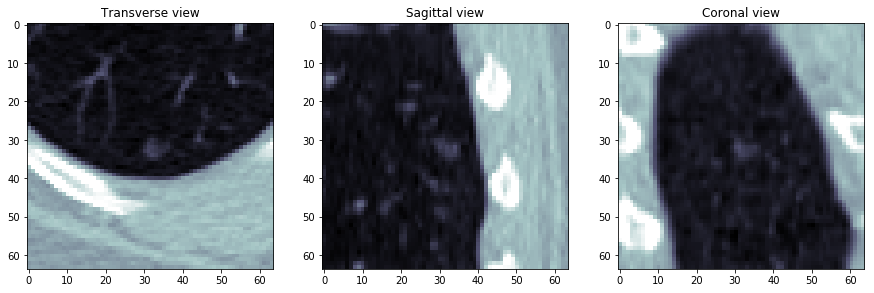

  1%|          | 1/89 [00:00<01:17,  1.13it/s]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd


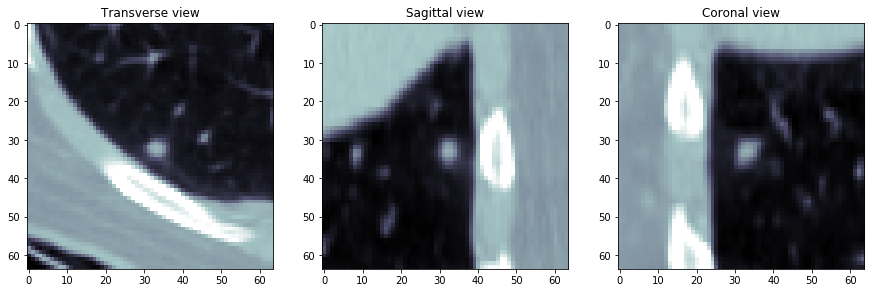

  3%|▎         | 3/89 [00:02<01:08,  1.25it/s]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd


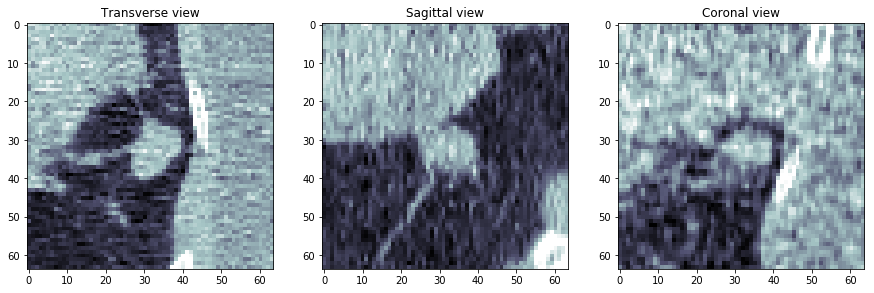

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd


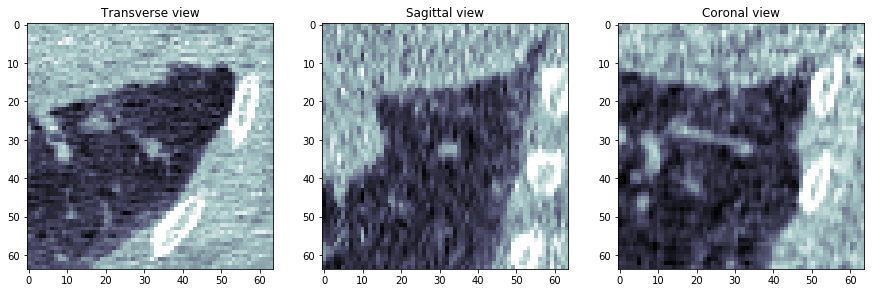

  4%|▍         | 4/89 [00:03<01:12,  1.17it/s]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.mhd


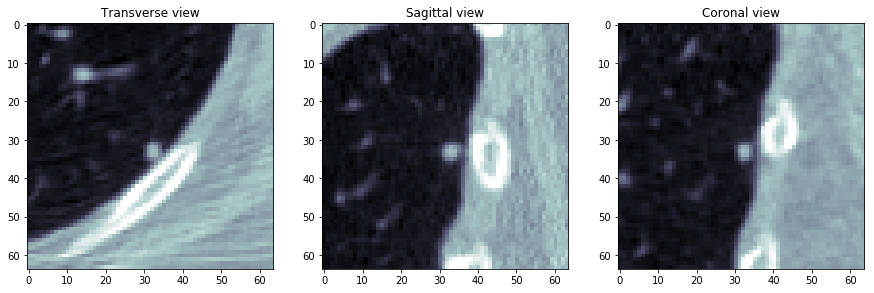

  6%|▌         | 5/89 [00:04<01:23,  1.01it/s]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565.mhd


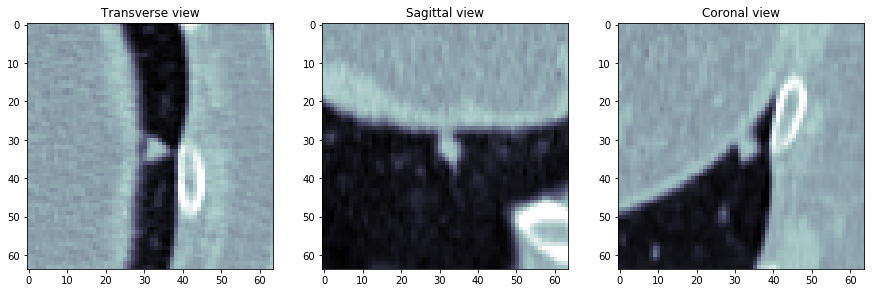

  7%|▋         | 6/89 [00:06<01:29,  1.08s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354.mhd


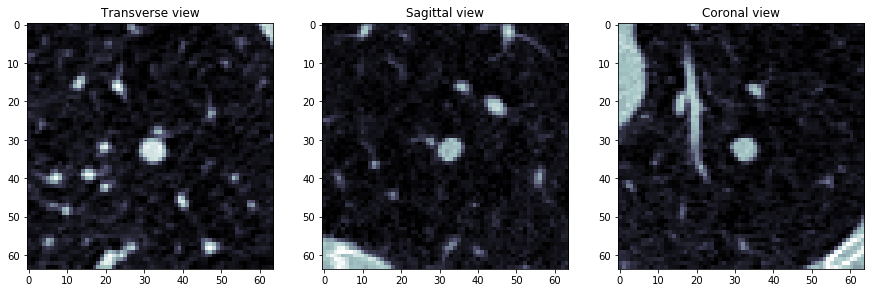

  9%|▉         | 8/89 [00:07<01:16,  1.07it/s]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912.mhd


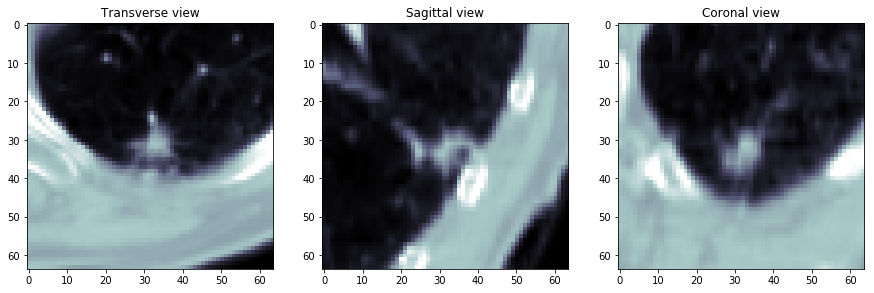

 10%|█         | 9/89 [00:08<01:19,  1.01it/s]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637338639741695800950.mhd


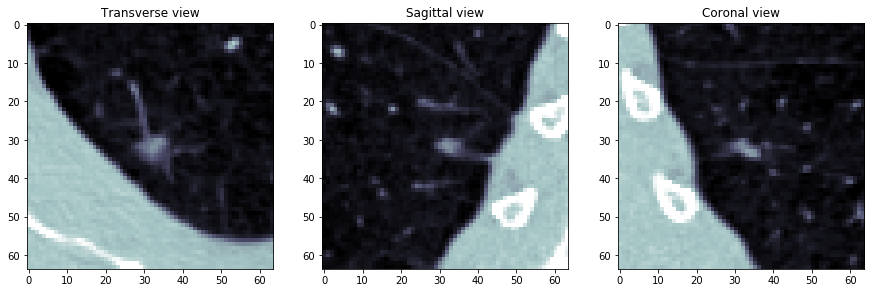

 11%|█         | 10/89 [00:10<01:20,  1.01s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843.mhd


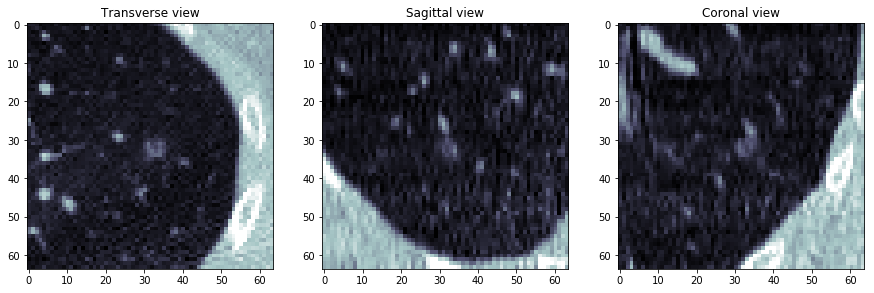

 12%|█▏        | 11/89 [00:11<01:19,  1.03s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441.mhd


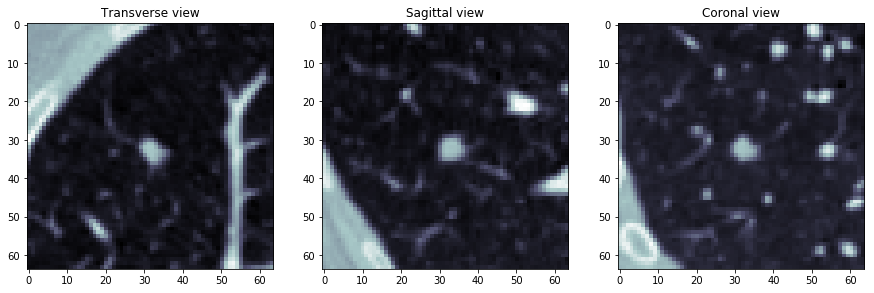

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441.mhd


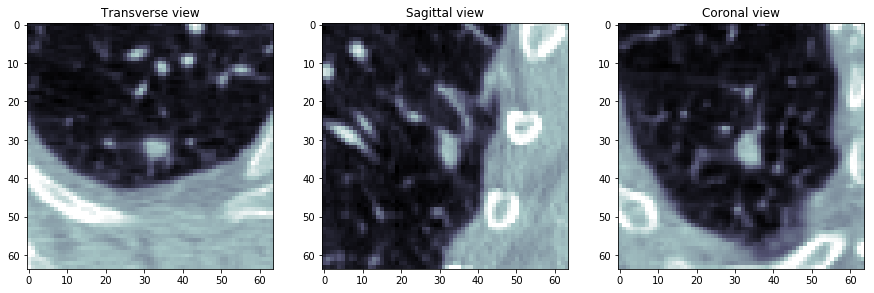

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441.mhd


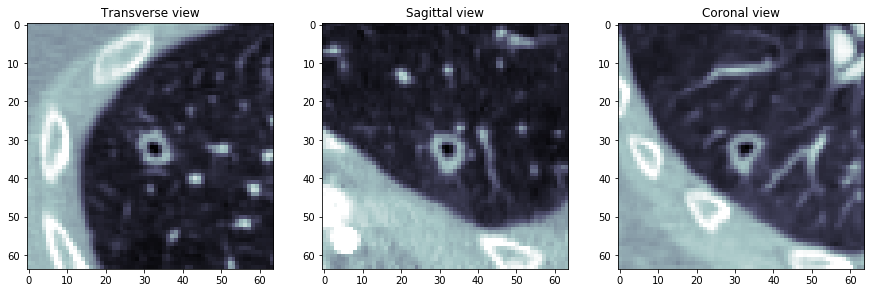

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441.mhd


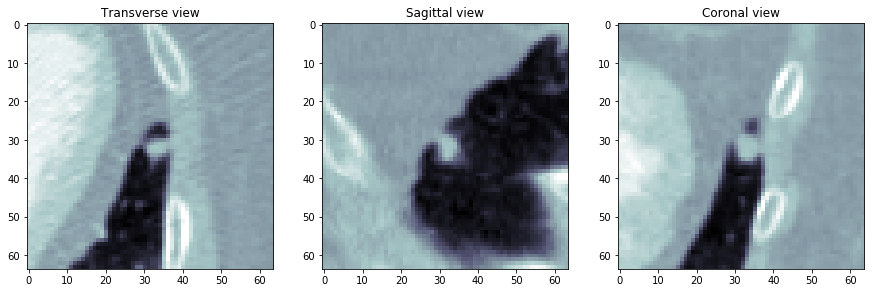

 13%|█▎        | 12/89 [00:13<01:27,  1.13s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097.mhd


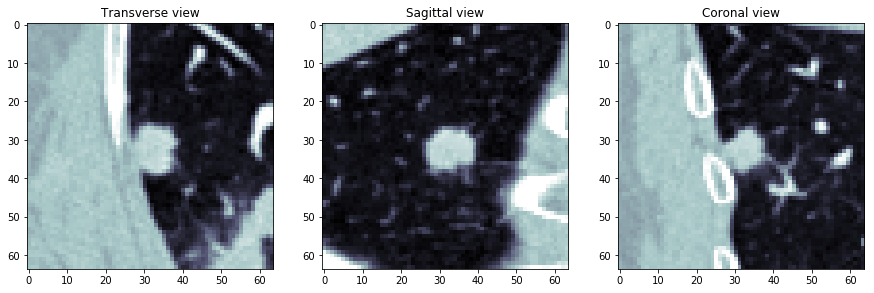

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097.mhd


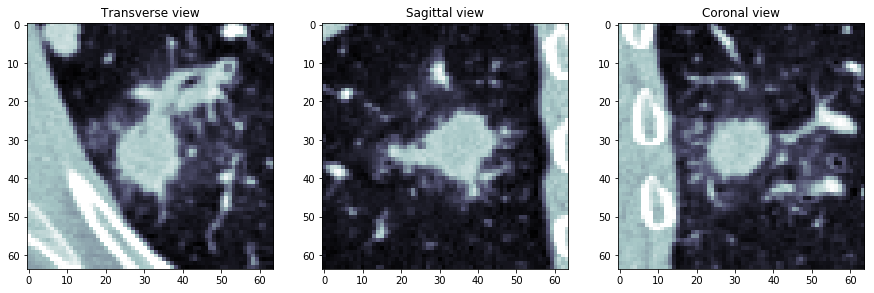

 15%|█▍        | 13/89 [00:15<01:28,  1.17s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.138080888843357047811238713686.mhd


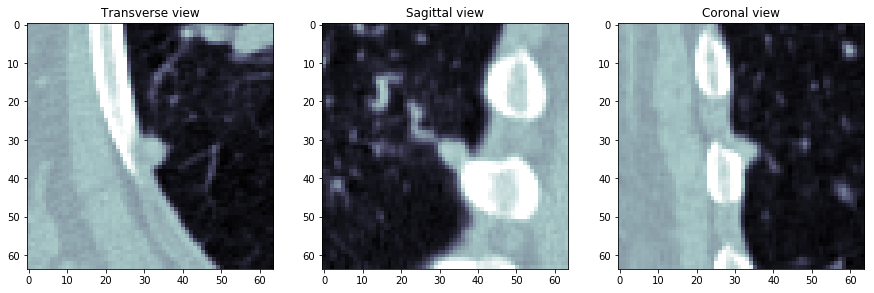

 17%|█▋        | 15/89 [00:16<01:20,  1.08s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952.mhd


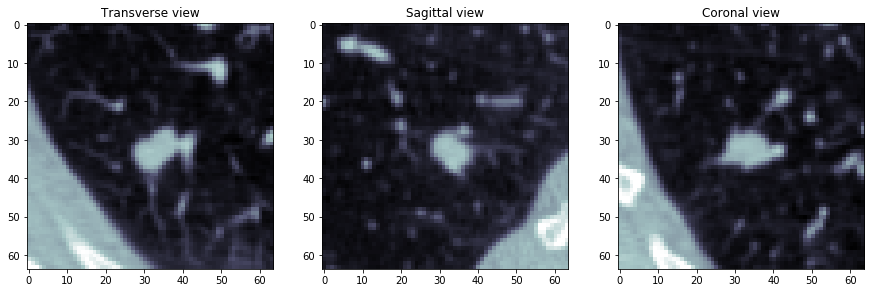

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952.mhd


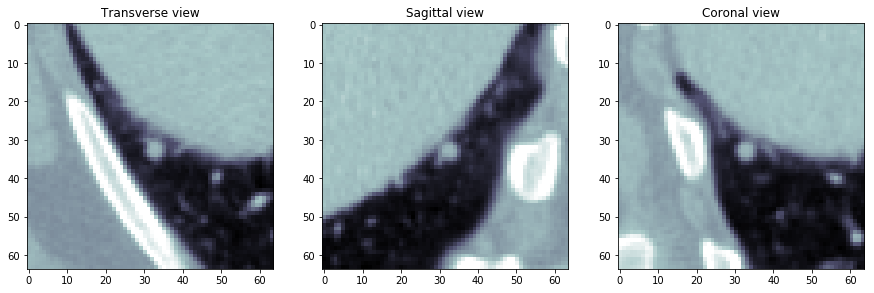

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952.mhd


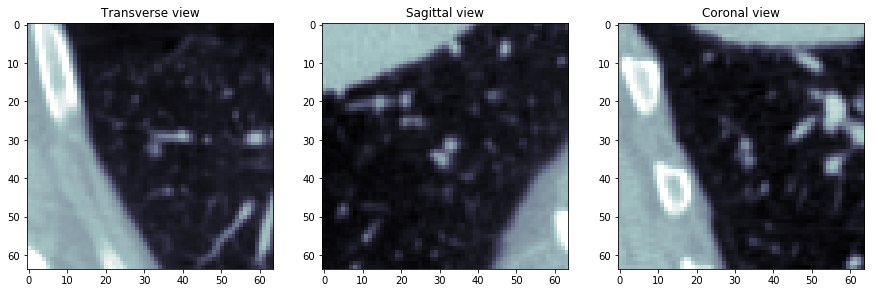

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952.mhd


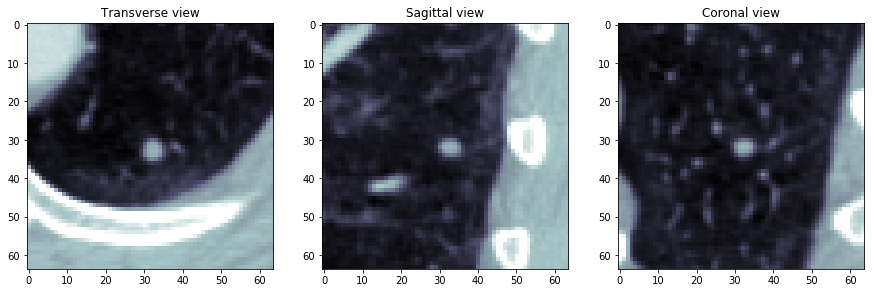

 18%|█▊        | 16/89 [00:18<01:23,  1.14s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.227962600322799211676960828223.mhd


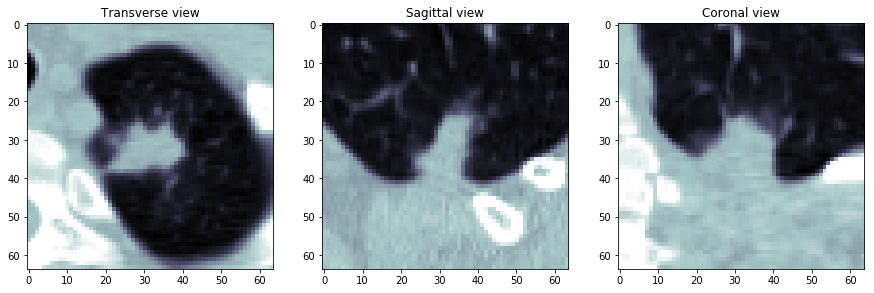

 19%|█▉        | 17/89 [00:19<01:22,  1.14s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.139258777898746693365877042411.mhd


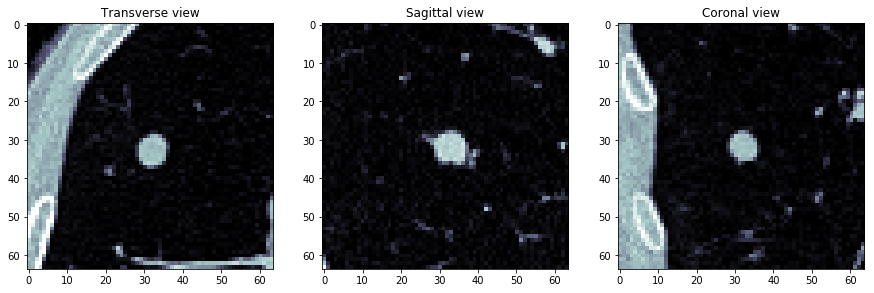

 20%|██        | 18/89 [00:20<01:19,  1.12s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762.mhd


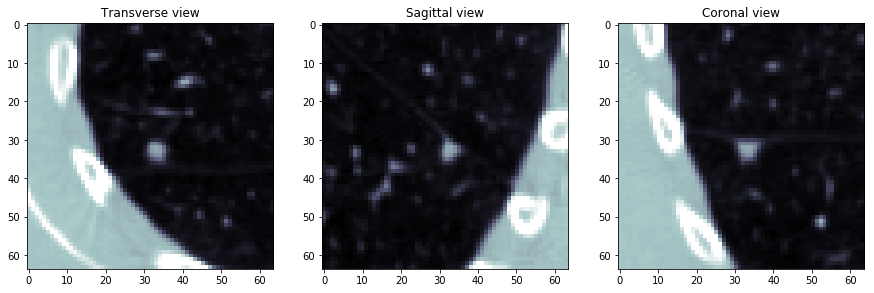

 22%|██▏       | 20/89 [00:20<01:12,  1.05s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.154677396354641150280013275227.mhd


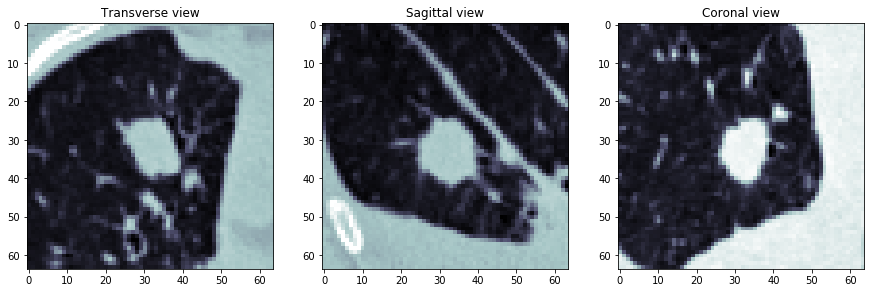

 26%|██▌       | 23/89 [00:22<01:04,  1.03it/s]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205085403623595258748.mhd


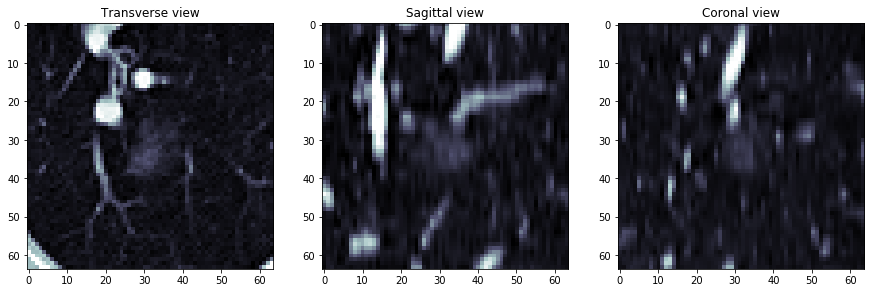

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205085403623595258748.mhd


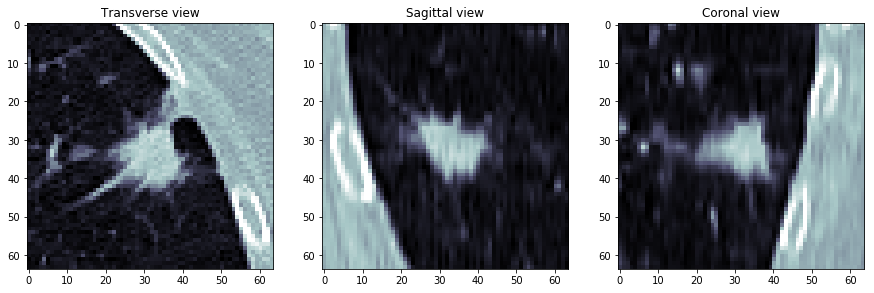

 27%|██▋       | 24/89 [00:24<01:05,  1.00s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188209889686363159853715266493.mhd


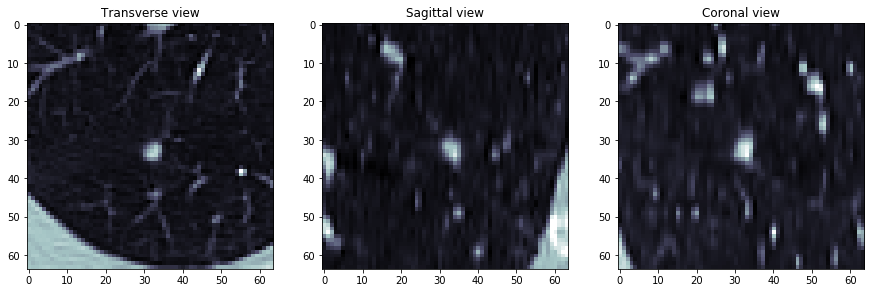

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188209889686363159853715266493.mhd


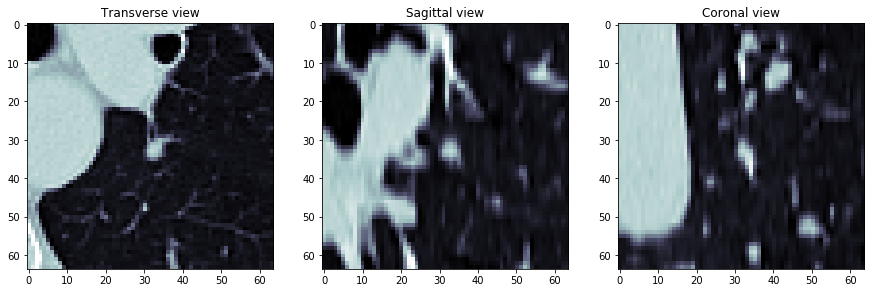

 28%|██▊       | 25/89 [00:25<01:06,  1.04s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326.mhd


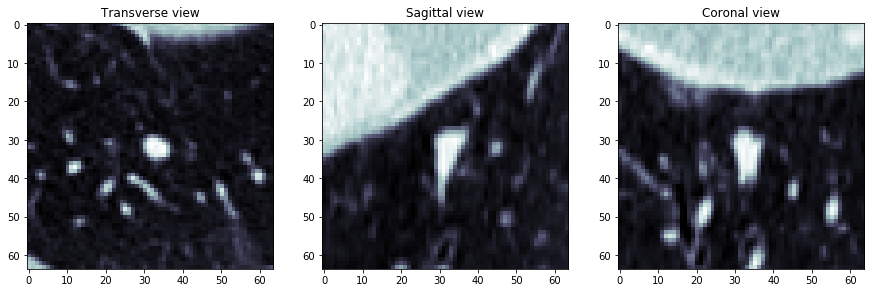

 29%|██▉       | 26/89 [00:27<01:06,  1.06s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.202811684116768680758082619196.mhd


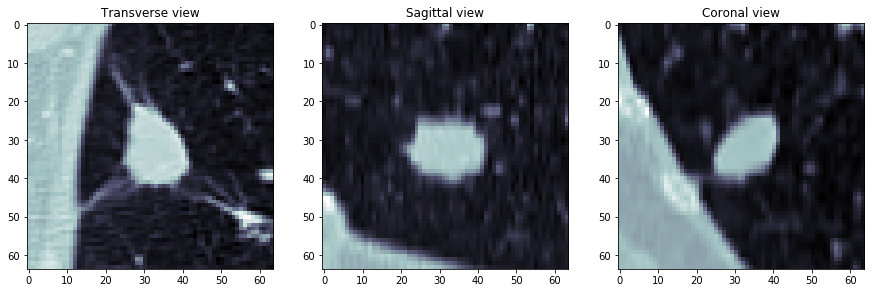

 31%|███▏      | 28/89 [00:30<01:05,  1.08s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.213140617640021803112060161074.mhd


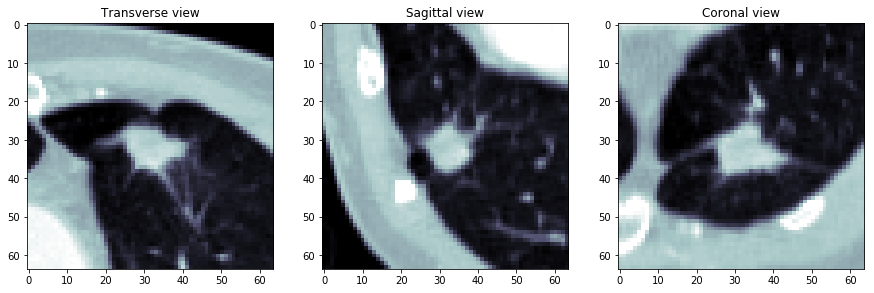

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.213140617640021803112060161074.mhd


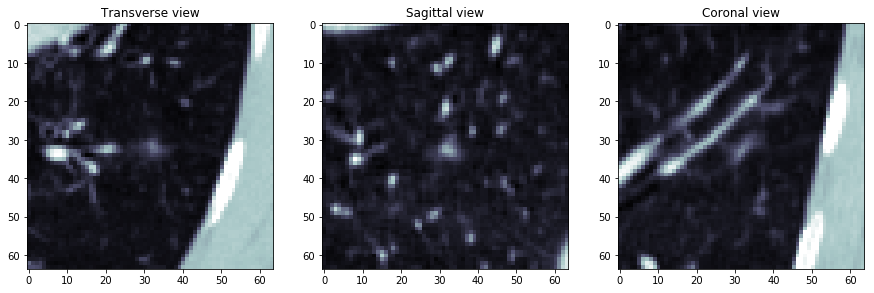

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.213140617640021803112060161074.mhd


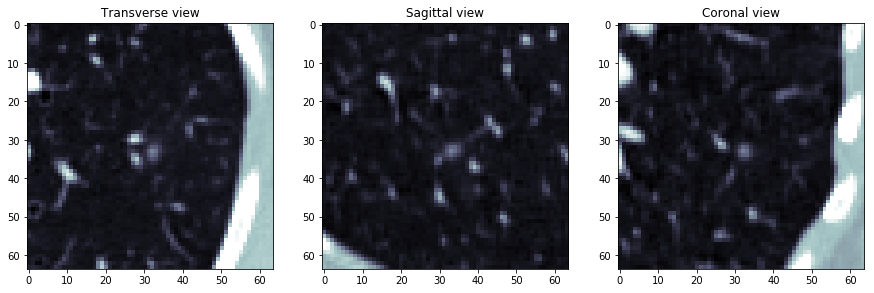

 34%|███▎      | 30/89 [00:31<01:02,  1.06s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.216882370221919561230873289517.mhd


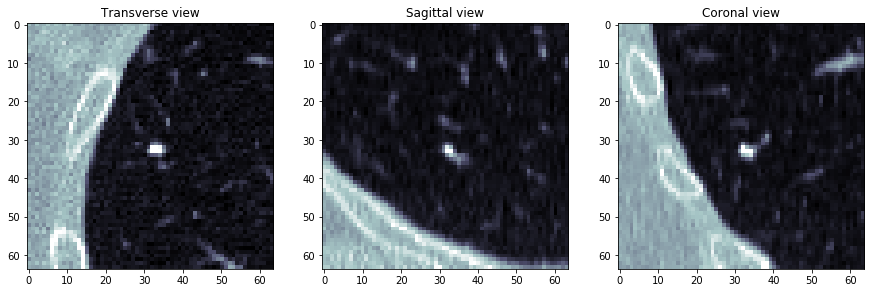

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.216882370221919561230873289517.mhd


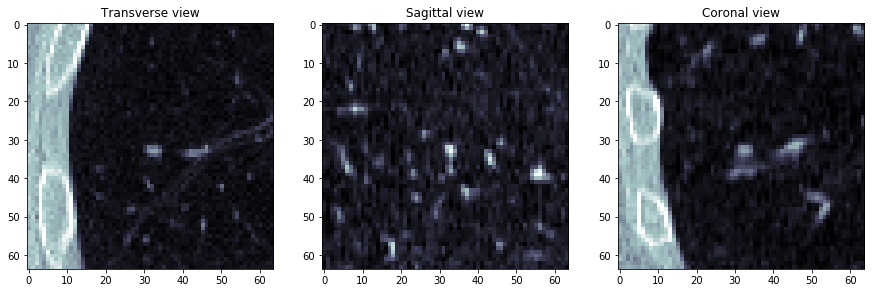

 35%|███▍      | 31/89 [00:33<01:02,  1.07s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729.mhd


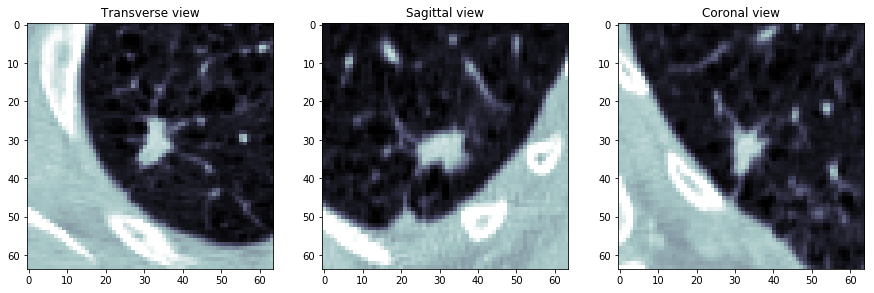

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729.mhd


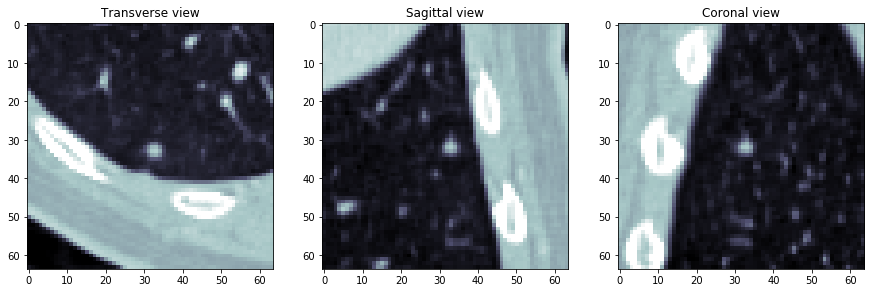

 36%|███▌      | 32/89 [00:34<01:01,  1.08s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179.mhd


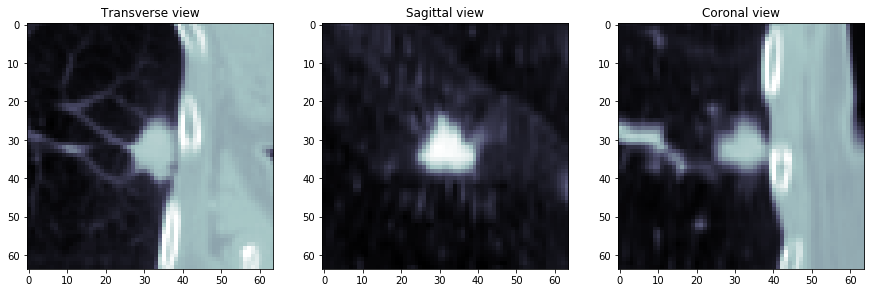

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179.mhd


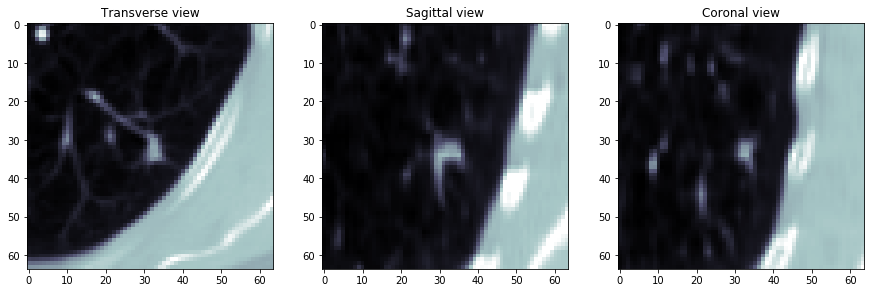

 37%|███▋      | 33/89 [00:36<01:02,  1.12s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.241570579760883349458693655367.mhd


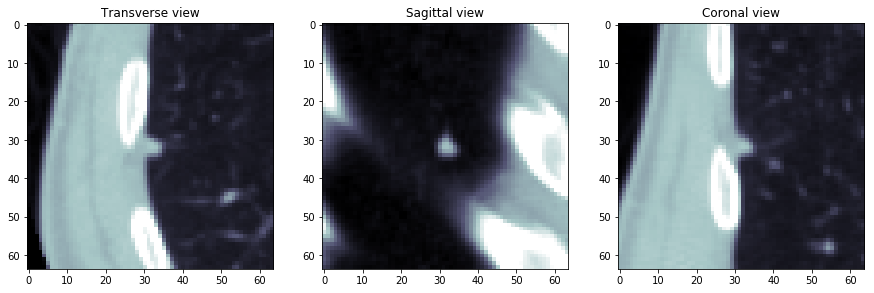

 40%|████      | 36/89 [00:39<00:58,  1.09s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.249530219848512542668813996730.mhd


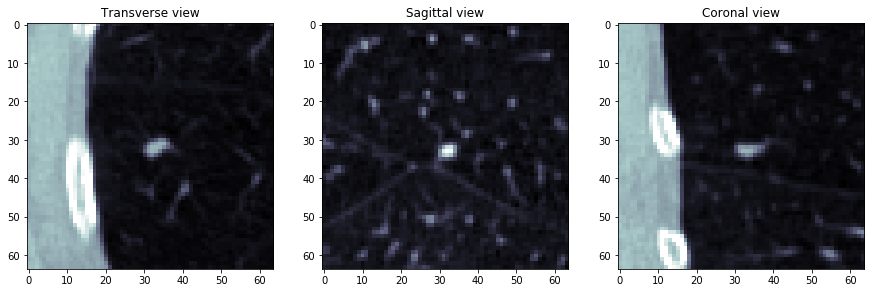

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.249530219848512542668813996730.mhd


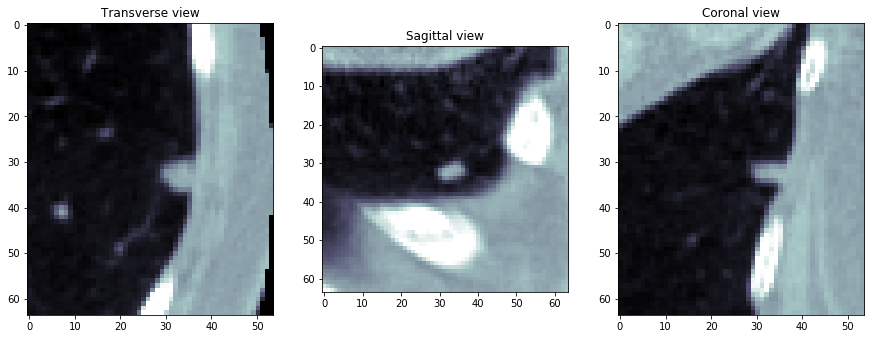

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.249530219848512542668813996730.mhd


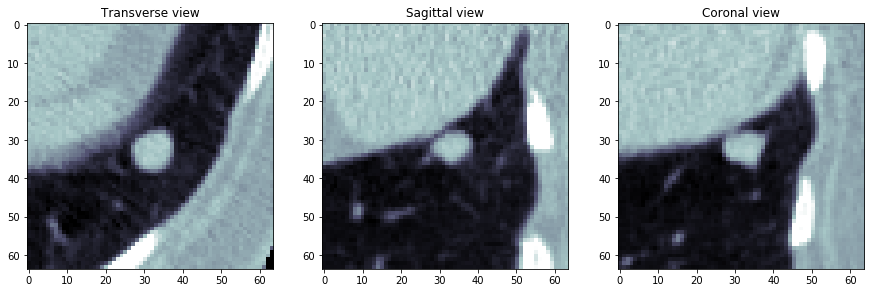

 42%|████▏     | 37/89 [00:43<01:00,  1.17s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250863365157630276148828903732.mhd


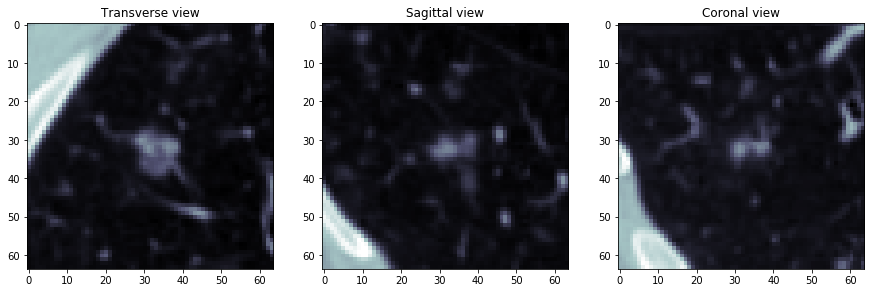

 44%|████▍     | 39/89 [00:47<01:00,  1.21s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.272042302501586336192628818865.mhd


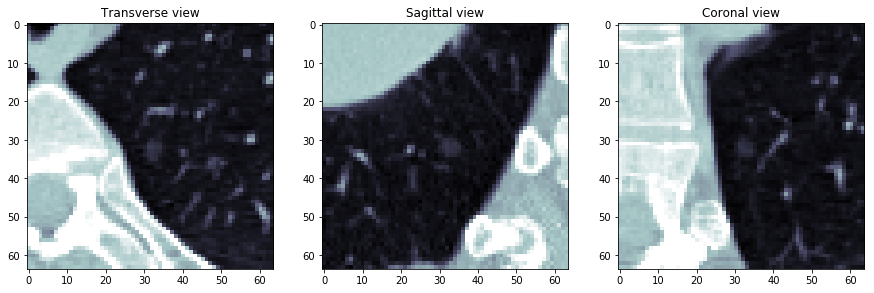

 46%|████▌     | 41/89 [00:49<00:57,  1.21s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.281489753704424911132261151767.mhd


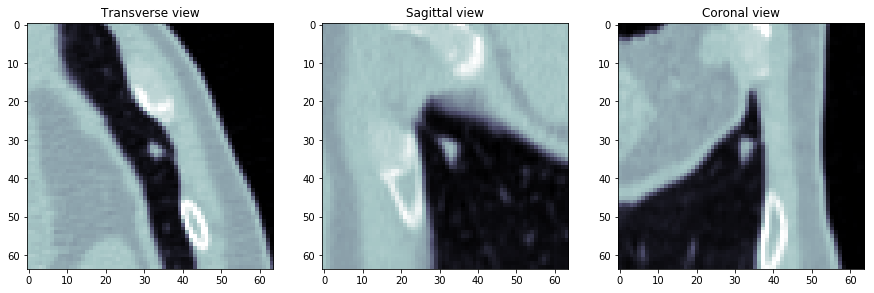

 49%|████▉     | 44/89 [00:52<00:53,  1.20s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.293757615532132808762625441831.mhd


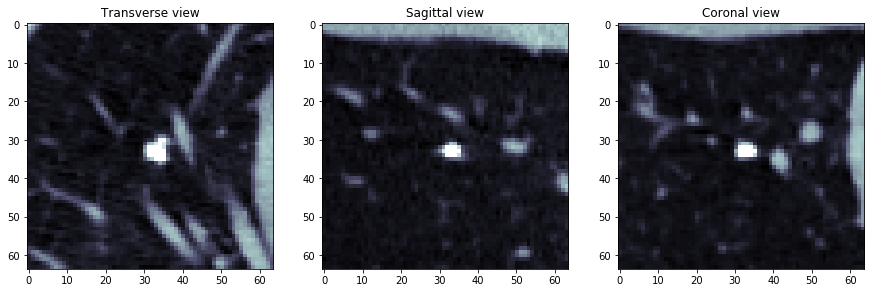

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.293757615532132808762625441831.mhd


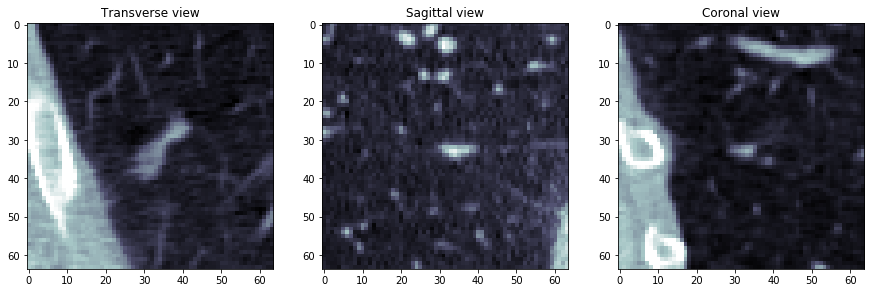

 51%|█████     | 45/89 [00:56<00:55,  1.26s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.294188507421106424248264912111.mhd


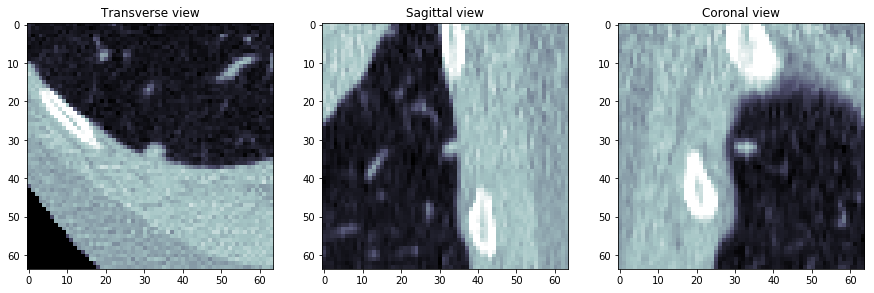

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.294188507421106424248264912111.mhd


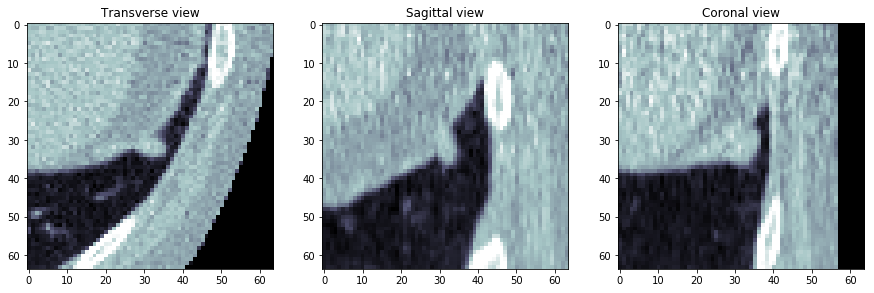

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.294188507421106424248264912111.mhd


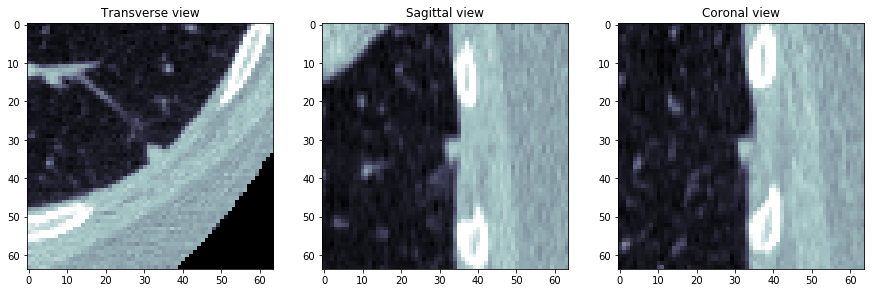

 52%|█████▏    | 46/89 [00:59<00:55,  1.29s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102631191572192562523.mhd


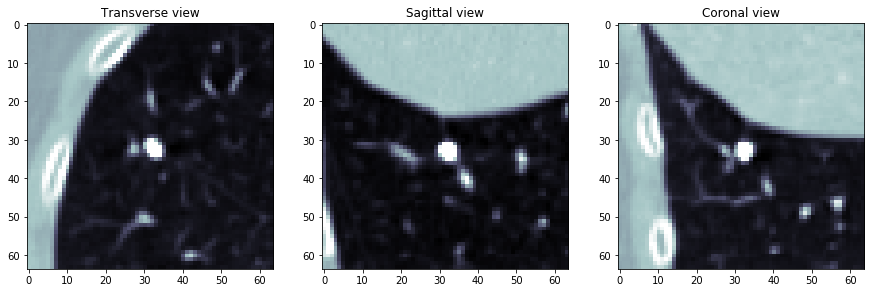

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102631191572192562523.mhd


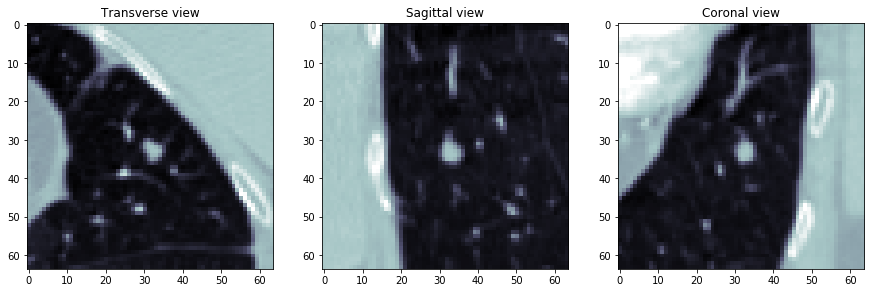

 53%|█████▎    | 47/89 [01:01<00:55,  1.32s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214095686326263147663.mhd


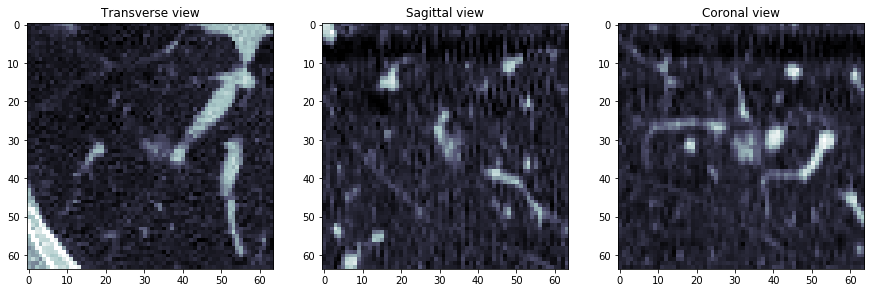

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214095686326263147663.mhd


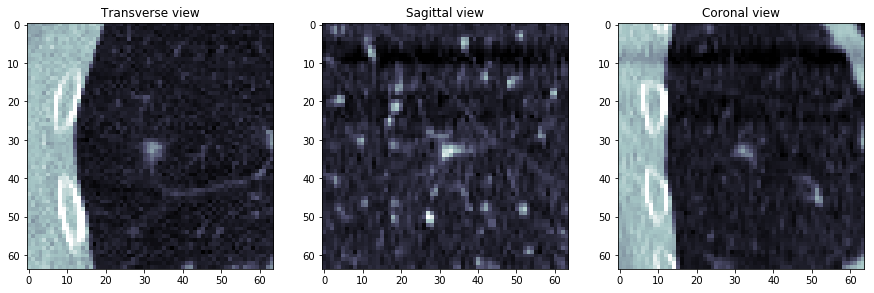

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214095686326263147663.mhd


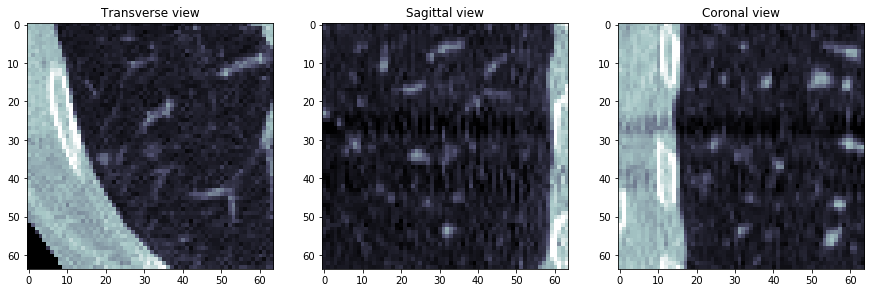

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214095686326263147663.mhd


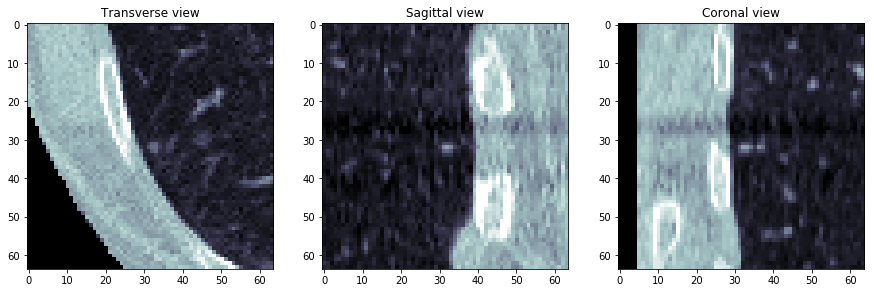

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214095686326263147663.mhd


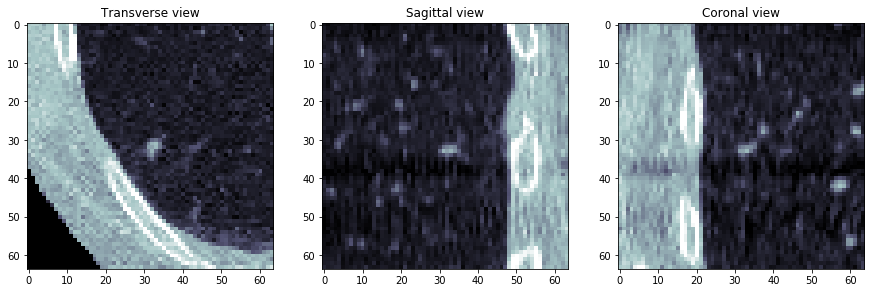

 54%|█████▍    | 48/89 [01:05<00:55,  1.36s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.305858704835252413616501469037.mhd


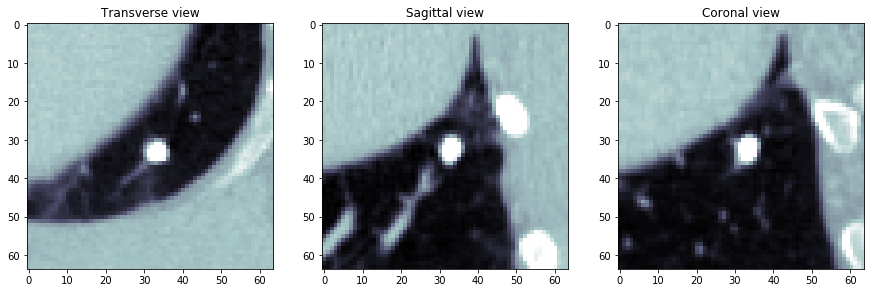

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.305858704835252413616501469037.mhd


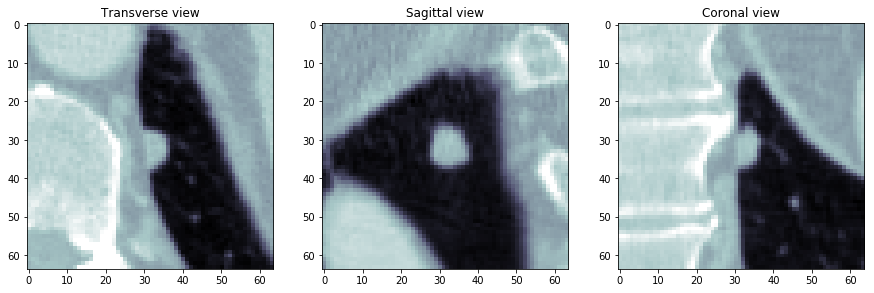

 56%|█████▌    | 50/89 [01:07<00:52,  1.36s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.310548927038333190233889983845.mhd


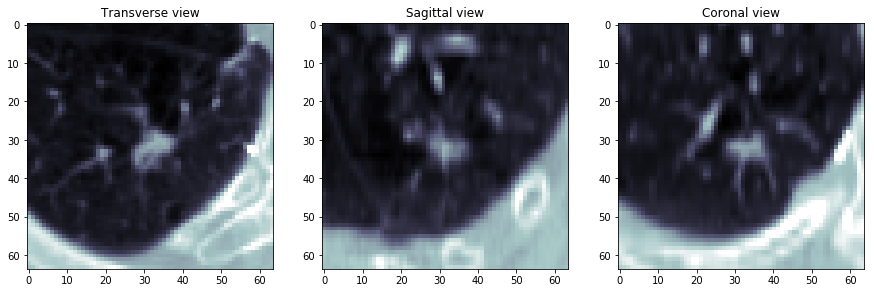

 57%|█████▋    | 51/89 [01:09<00:51,  1.37s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313334055029671473836954456733.mhd


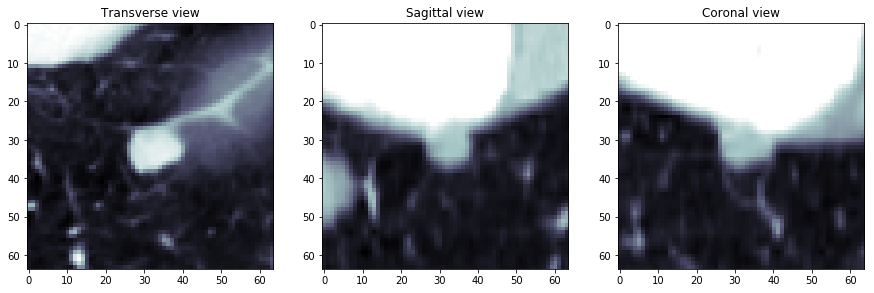

 61%|██████    | 54/89 [01:11<00:46,  1.33s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313605260055394498989743099991.mhd


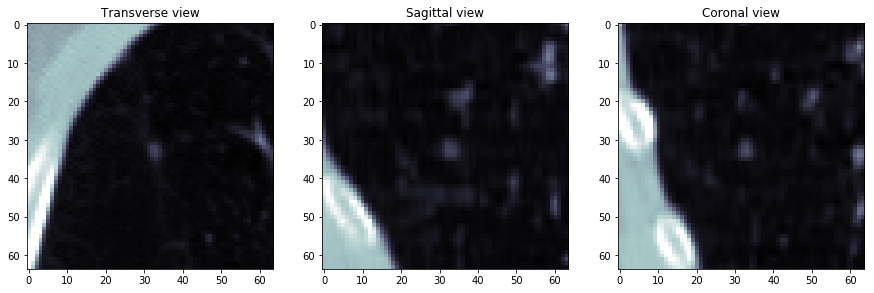

 62%|██████▏   | 55/89 [01:13<00:45,  1.34s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313835996725364342034830119490.mhd


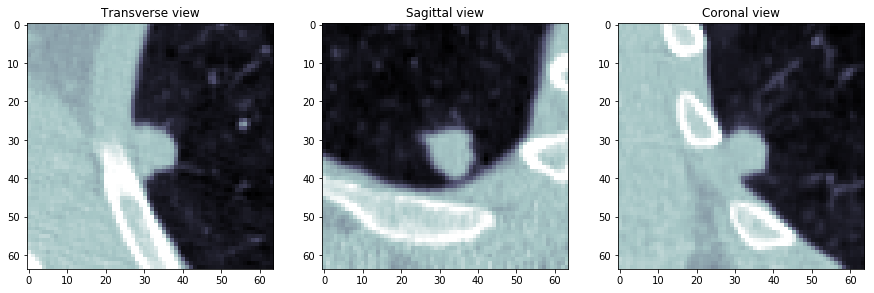

 63%|██████▎   | 56/89 [01:17<00:45,  1.38s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.317087518531899043292346860596.mhd


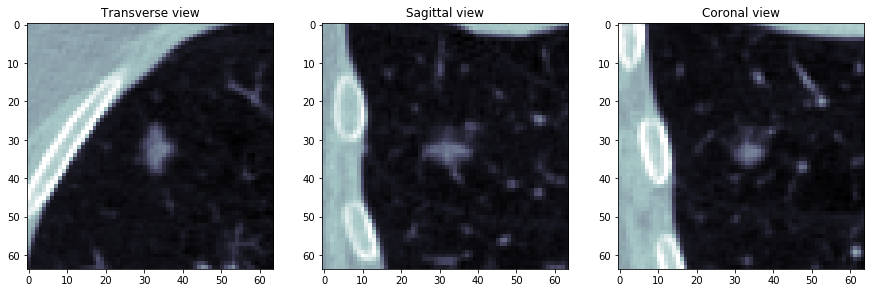

 64%|██████▍   | 57/89 [01:20<00:45,  1.41s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323859712968543712594665815359.mhd


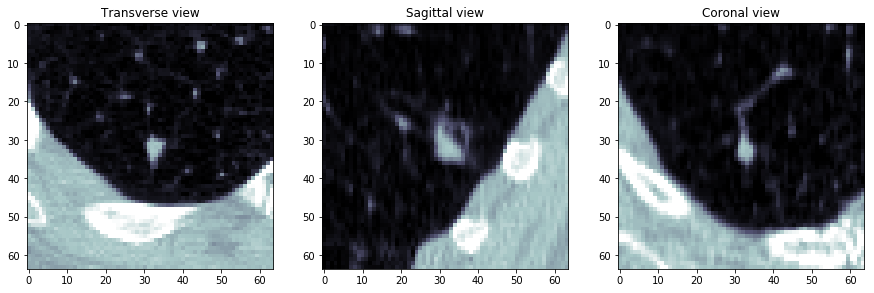

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323859712968543712594665815359.mhd


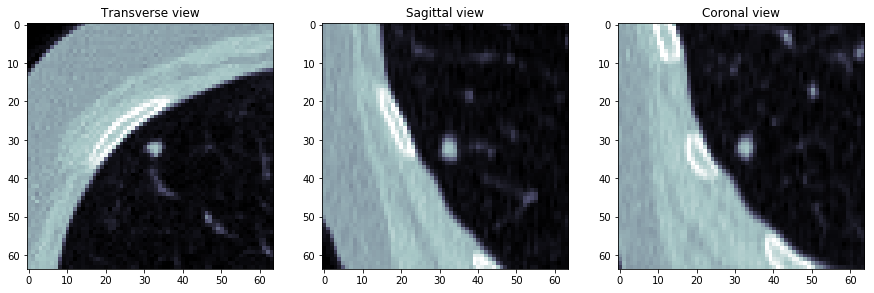

 65%|██████▌   | 58/89 [01:23<00:44,  1.43s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.333145094436144085379032922488.mhd


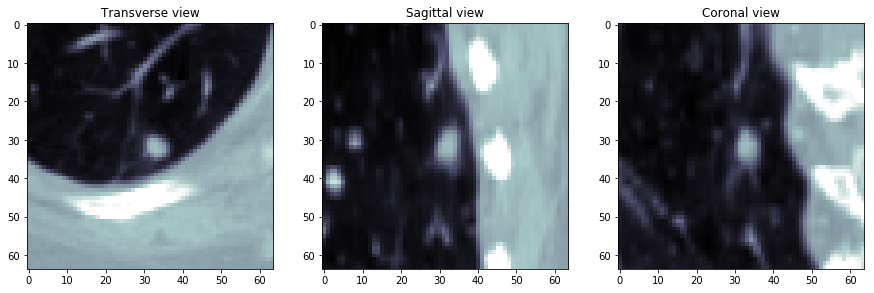

 67%|██████▋   | 60/89 [01:25<00:41,  1.42s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.334517907433161353885866806005.mhd


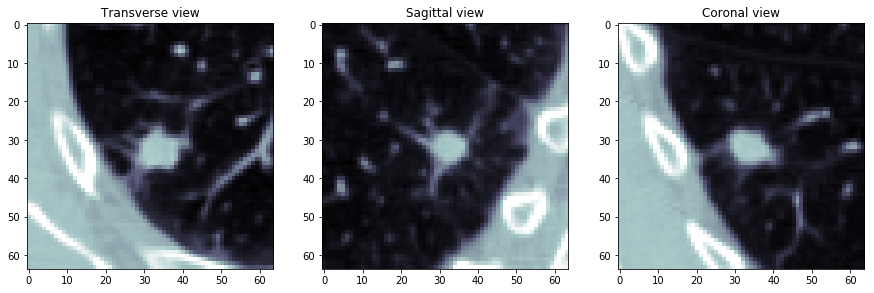

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.334517907433161353885866806005.mhd


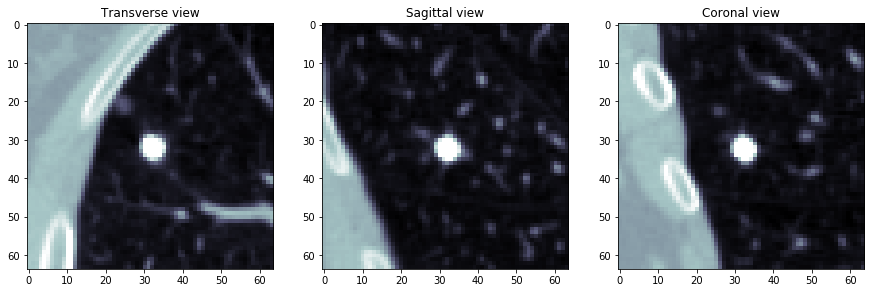

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.334517907433161353885866806005.mhd


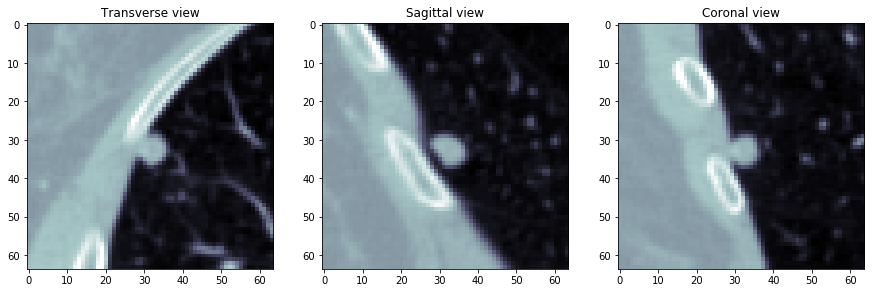

 69%|██████▊   | 61/89 [01:28<00:40,  1.45s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.395623571499047043765181005112.mhd


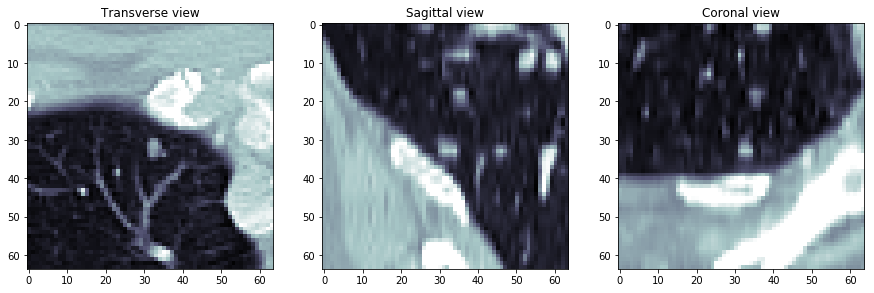

 70%|██████▉   | 62/89 [01:30<00:39,  1.46s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.404364125369979066736354549484.mhd


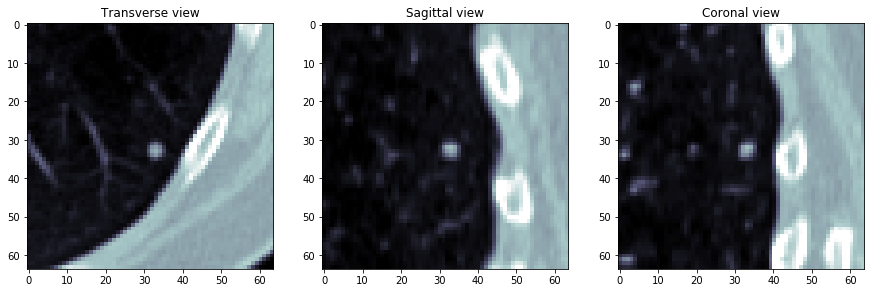

 72%|███████▏  | 64/89 [01:32<00:36,  1.44s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.417815314896088956784723476543.mhd


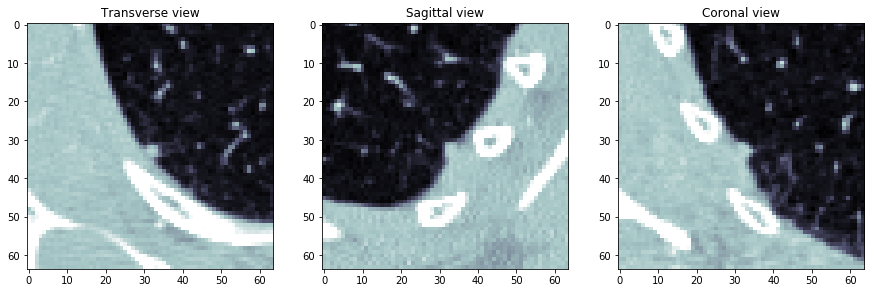

 73%|███████▎  | 65/89 [01:34<00:34,  1.45s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.450501966058662668272378865145.mhd


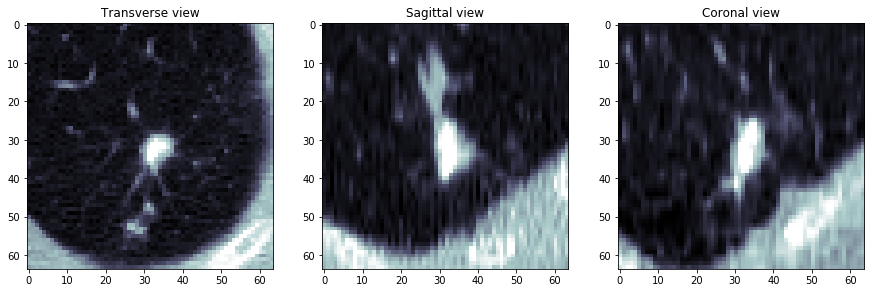

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.450501966058662668272378865145.mhd


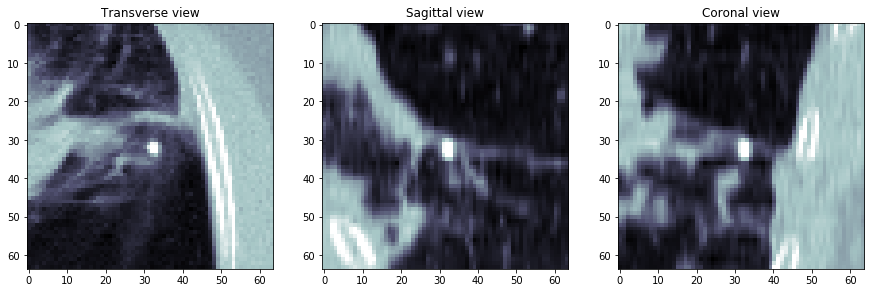

 74%|███████▍  | 66/89 [01:36<00:33,  1.46s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.511347030803753100045216493273.mhd


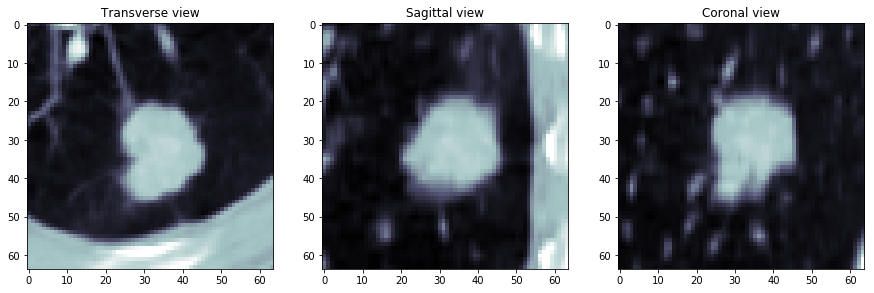

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.511347030803753100045216493273.mhd


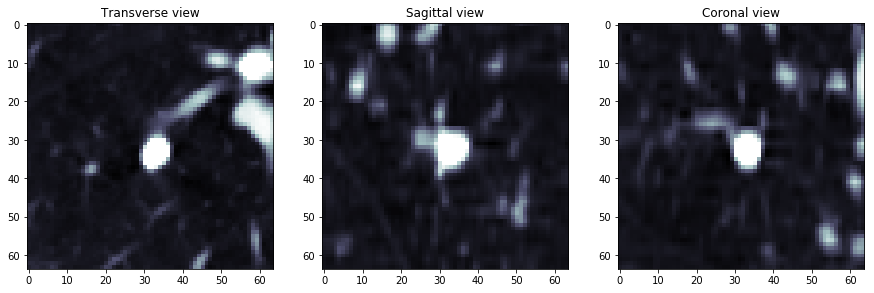

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.511347030803753100045216493273.mhd


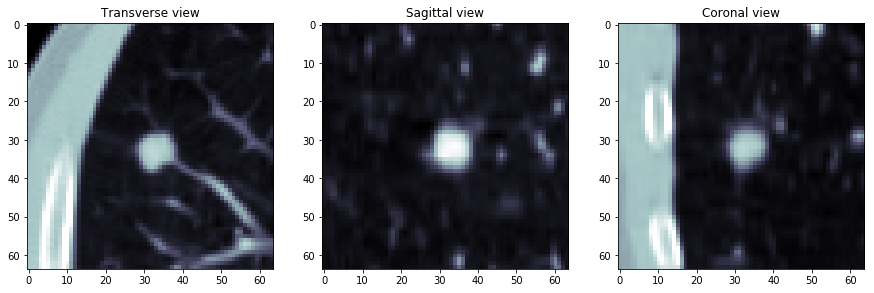

 75%|███████▌  | 67/89 [01:39<00:32,  1.48s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.525937963993475482158828421281.mhd


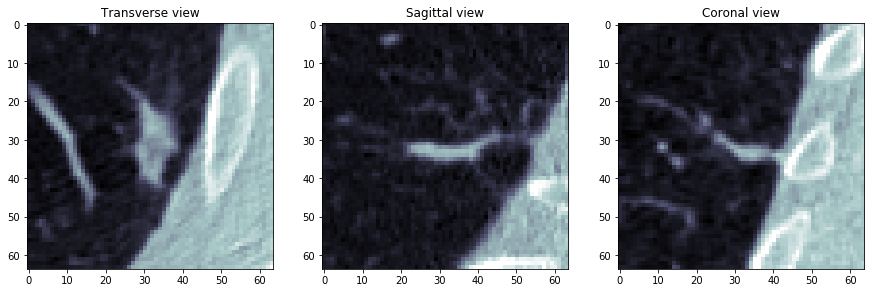

 76%|███████▋  | 68/89 [01:43<00:31,  1.52s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256943390479252771547.mhd


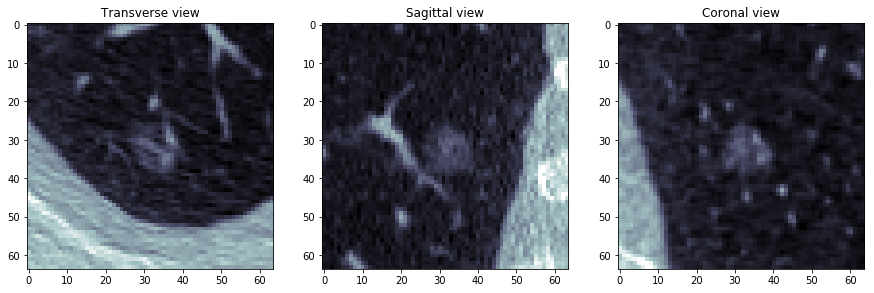

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256943390479252771547.mhd


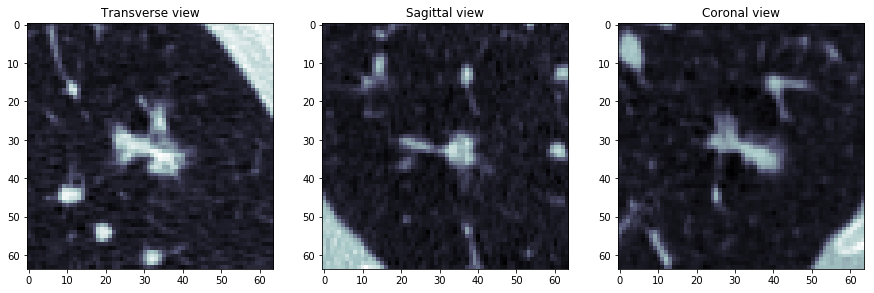

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256943390479252771547.mhd


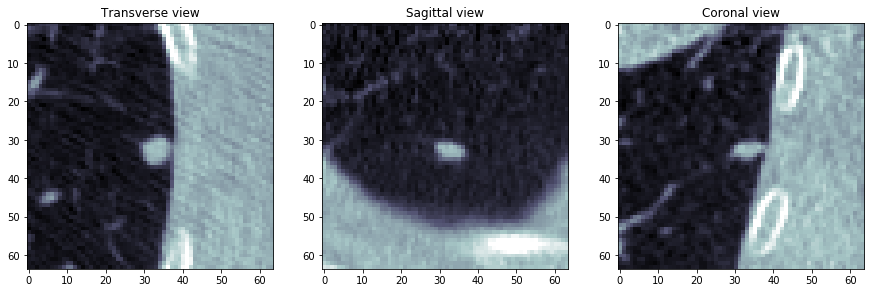

 78%|███████▊  | 69/89 [01:47<00:31,  1.56s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.303421828981831854739626597495.mhd


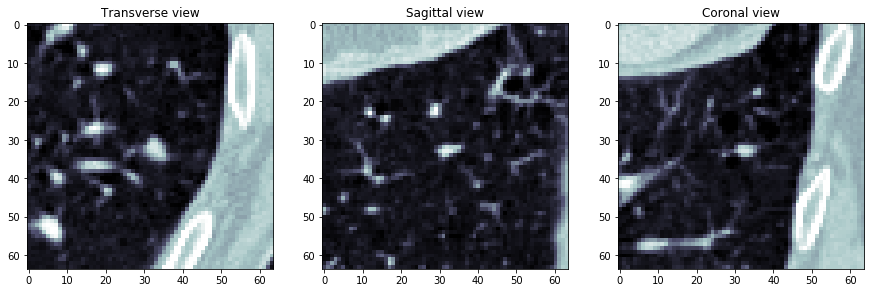

 79%|███████▊  | 70/89 [01:50<00:29,  1.58s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323302986710576400812869264321.mhd


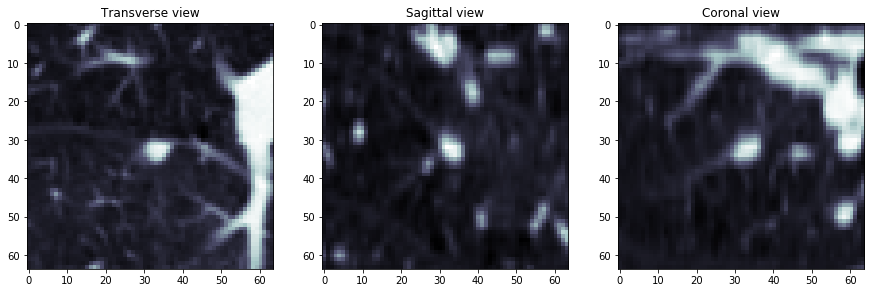

 80%|███████▉  | 71/89 [01:52<00:28,  1.58s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.430109407146633213496148200410.mhd


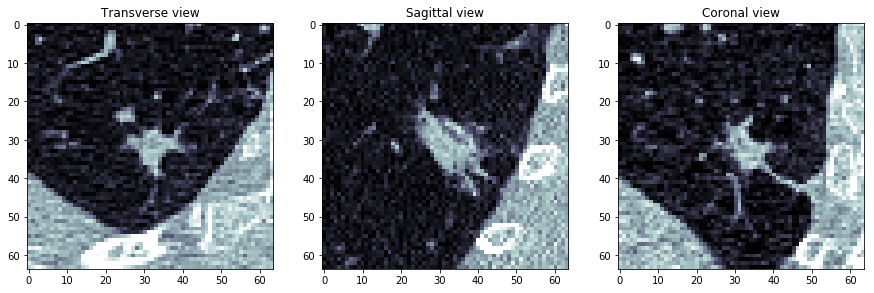

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.430109407146633213496148200410.mhd


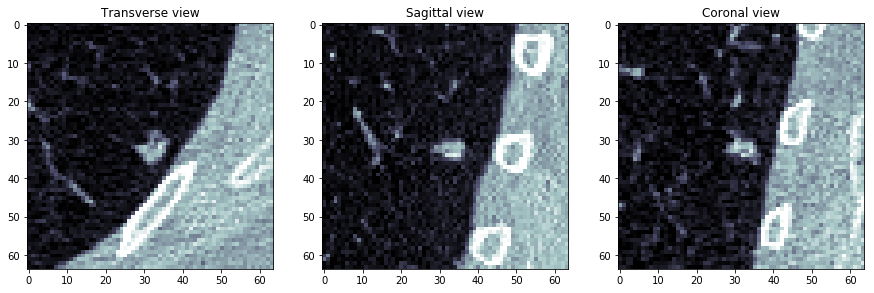

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.430109407146633213496148200410.mhd


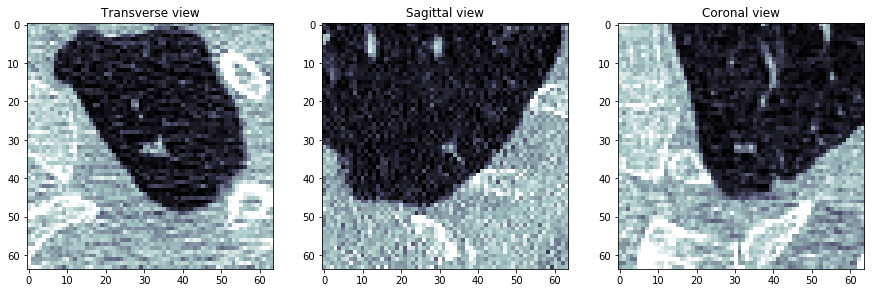

 81%|████████  | 72/89 [01:57<00:27,  1.63s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.640729228179368154416184318668.mhd


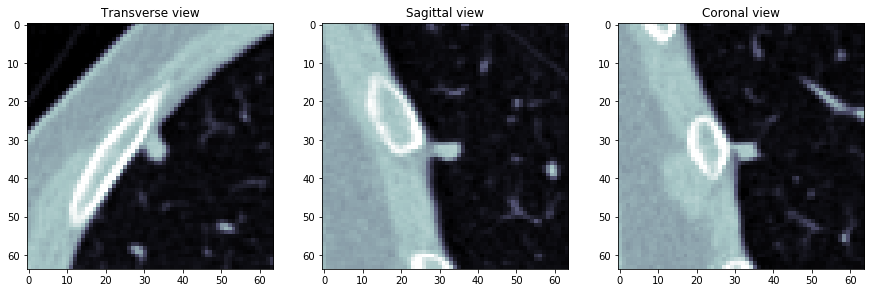

 82%|████████▏ | 73/89 [02:01<00:26,  1.66s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.898642529028521482602829374444.mhd


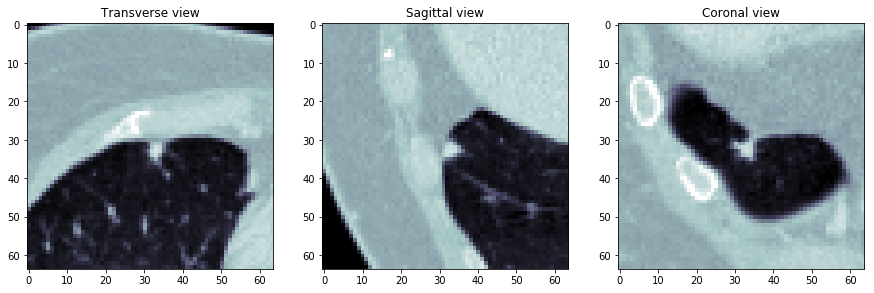

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.898642529028521482602829374444.mhd


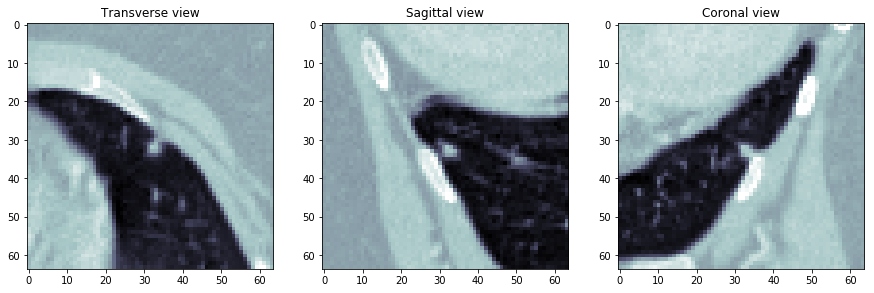

 83%|████████▎ | 74/89 [02:03<00:24,  1.66s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.534083630500464995109143618896.mhd


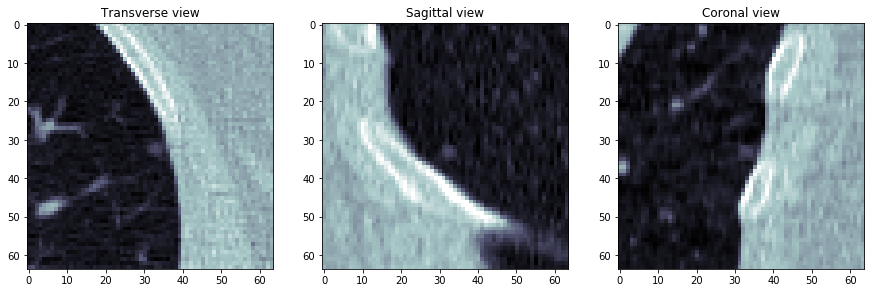

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.534083630500464995109143618896.mhd


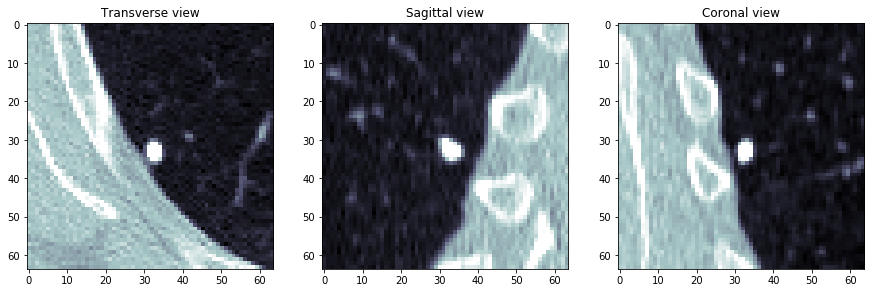

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.534083630500464995109143618896.mhd


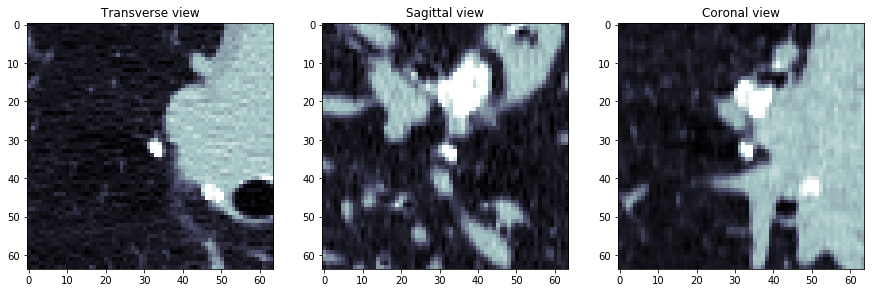

 84%|████████▍ | 75/89 [02:05<00:23,  1.68s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.566816709786169715745131047975.mhd


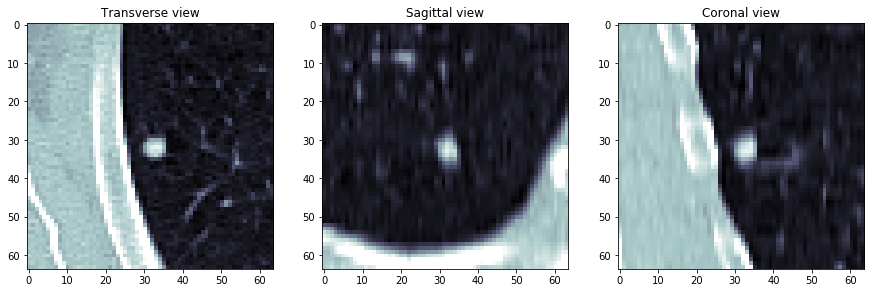

 87%|████████▋ | 77/89 [02:08<00:19,  1.66s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.621916089407825046337959219998.mhd


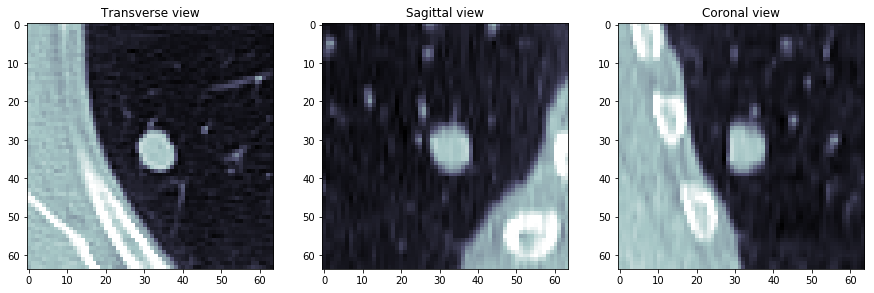

 88%|████████▊ | 78/89 [02:10<00:18,  1.67s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.716498695101447665580610403574.mhd


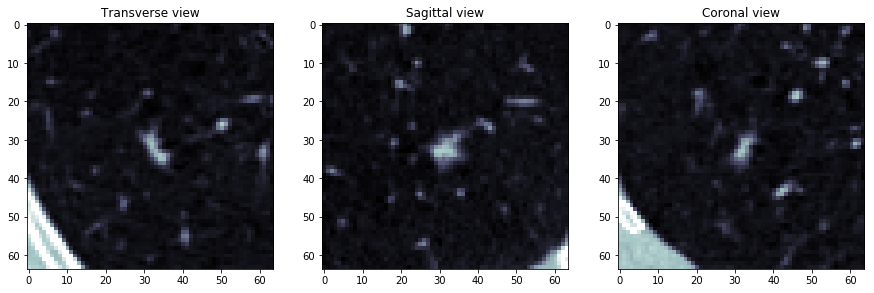

 90%|████████▉ | 80/89 [02:13<00:15,  1.67s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.724251104254976962355686318345.mhd


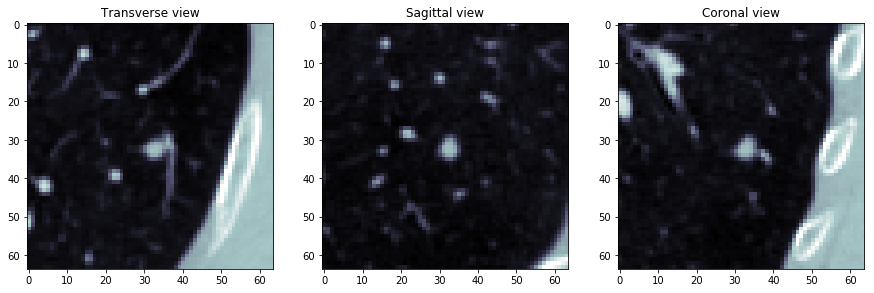

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.724251104254976962355686318345.mhd


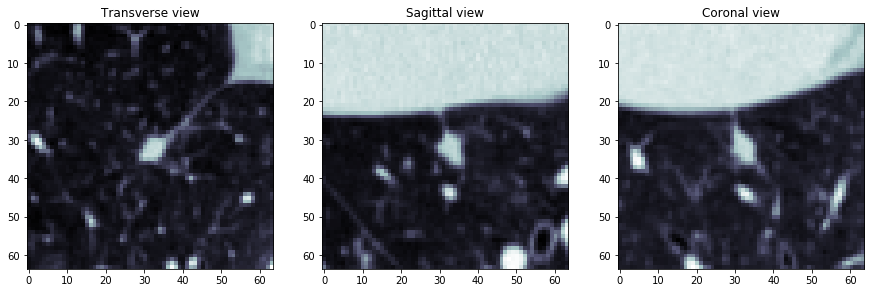

 91%|█████████ | 81/89 [02:16<00:13,  1.69s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.752756872840730509471096155114.mhd


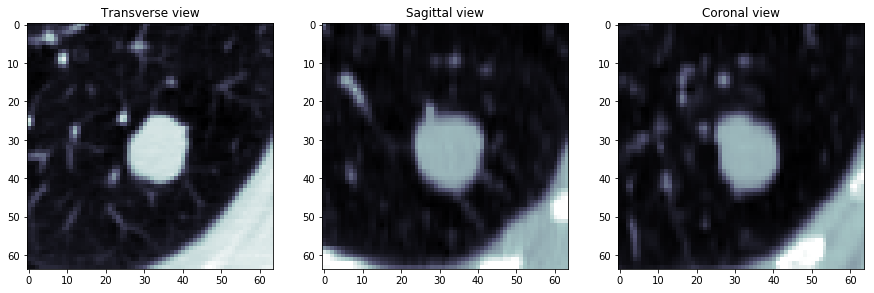

 92%|█████████▏| 82/89 [02:18<00:11,  1.69s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.805925269324902055566754756843.mhd


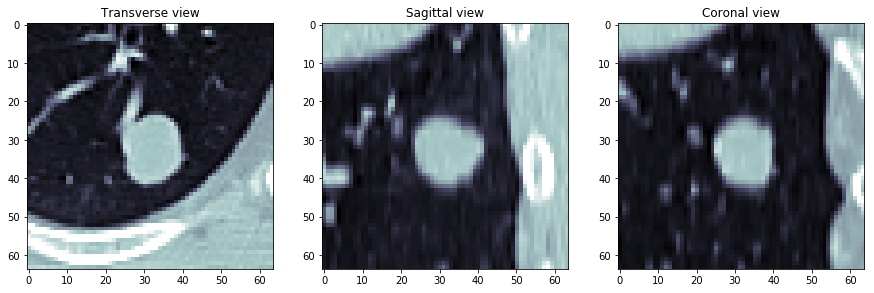

 93%|█████████▎| 83/89 [02:21<00:10,  1.70s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.826812708000318290301835871780.mhd


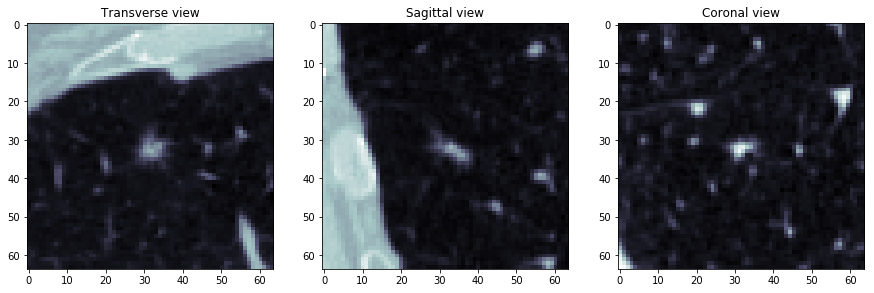

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.826812708000318290301835871780.mhd


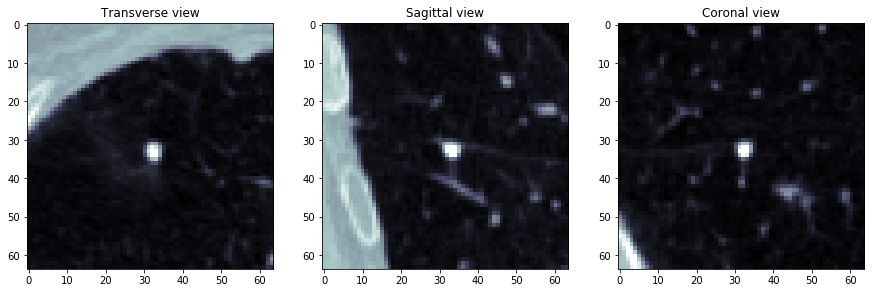

 94%|█████████▍| 84/89 [02:24<00:08,  1.72s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.832260670372728970918746541371.mhd


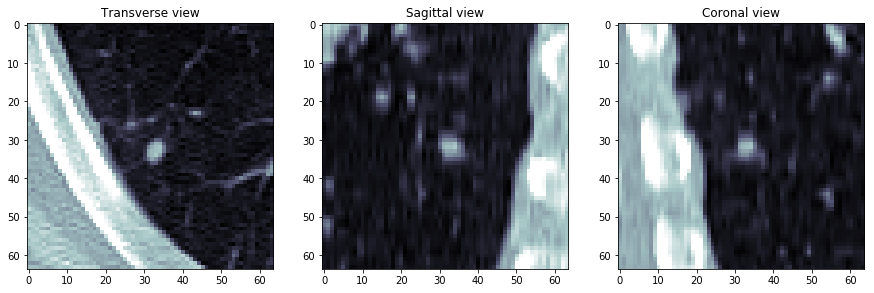

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.832260670372728970918746541371.mhd


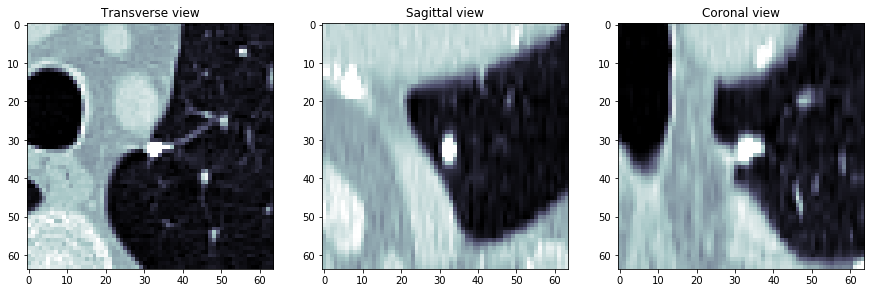

 96%|█████████▌| 85/89 [02:27<00:06,  1.74s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.868211851413924881662621747734.mhd


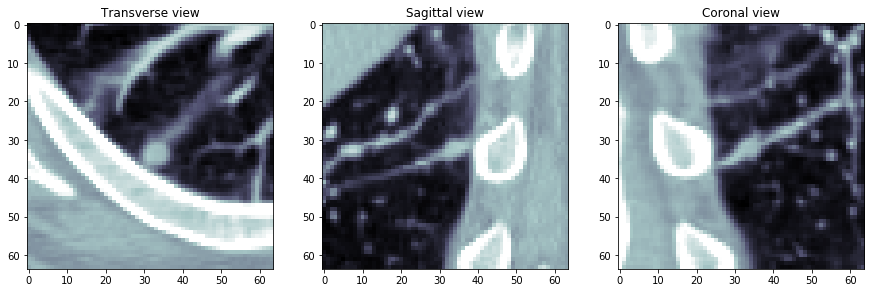

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.868211851413924881662621747734.mhd


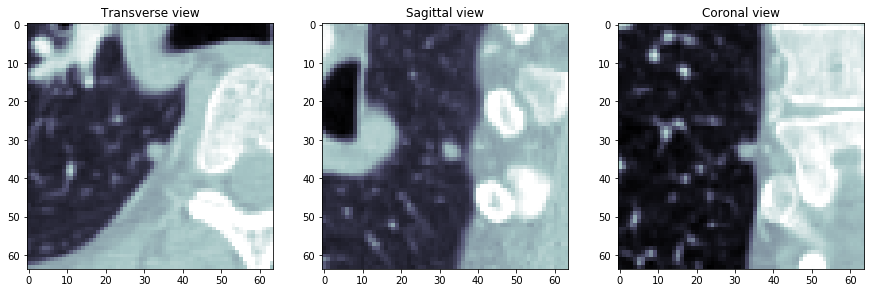

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.868211851413924881662621747734.mhd


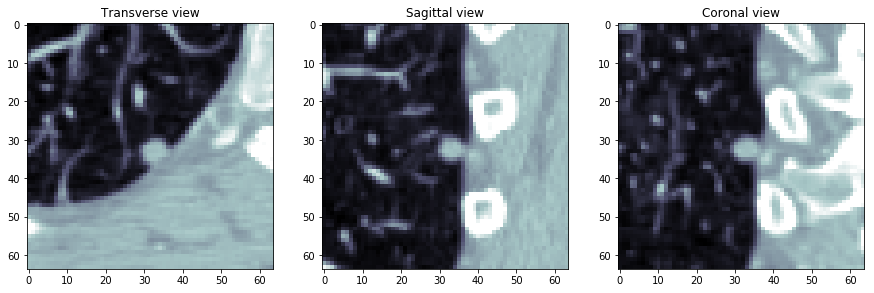

 97%|█████████▋| 86/89 [02:31<00:05,  1.76s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.905371958588660410240398317235.mhd


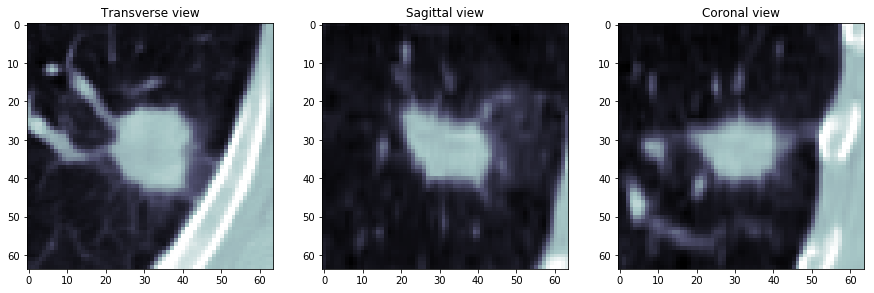

 98%|█████████▊| 87/89 [02:33<00:03,  1.77s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707182900091062408058.mhd


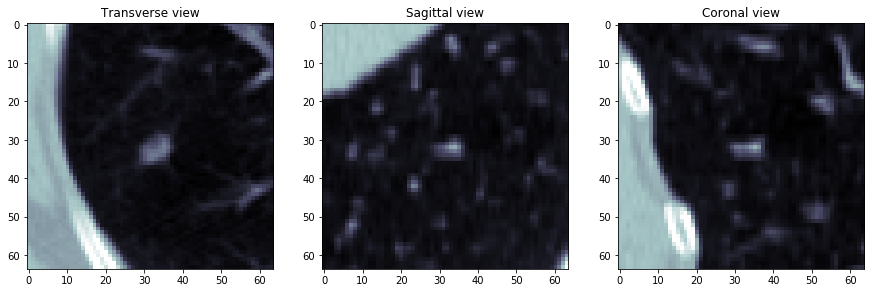

100%|██████████| 89/89 [02:35<00:00,  1.75s/it]


In [8]:
#####
#
# Looping over the image files
#
for fcount, img_file in enumerate(tqdm(file_list)):
    
    mini_df = df_node[df_node["file"]==img_file] #get all nodules associate with file
    
    
    
    if mini_df.shape[0]>0: # some files may not have a nodule--skipping those 
        
        '''
        Extracts 2D patches from the 3 planes (transverse, coronal, and sagittal).
        
        The sticky point here is the order of the axes. Numpy is z,y,x and SimpleITK is x,y,z.
        I've found it very difficult to keep the order correct when going back and forth,
        but this code seems to pass the sanity checks.
        '''
        # Load the CT scan (3D .mhd file)
        itk_img = sitk.ReadImage(img_file)  # indices are x,y,z (note the ordering of dimesions)
        
        # Normalize the image spacing so that a voxel is 1x1x1 mm in dimension
        itk_img = normalize_img(itk_img)
       
        # SimpleITK keeps the origin and spacing information for the 3D image volume
        img_array = sitk.GetArrayFromImage(itk_img) # indices are z,y,x (note the ordering of dimesions)
        slice_z, height, width = img_array.shape        
        origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm) - Not same as img_array
        spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coordinates (mm)
        
        for candidate_idx, cur_row in mini_df.iterrows(): # Iterate through all candidates
            
            # This is the real world x,y,z coordinates of possible nodule (in mm)
            candidate_x = cur_row['coordX']
            candidate_y = cur_row['coordY']
            candidate_z = cur_row['coordZ']
            diam = cur_row['diameter_mm']  # Only defined for true positives
            
            mask_width = 32 # This is really the half width so window will be double this width
            mask_height = 32 # This is really the half height so window will be double this height
            mask_depth = 32 # This is really the half depth so window will be double this depth
            
            center = np.array([candidate_x, candidate_y, candidate_z])   # candidate center
            voxel_center = np.rint((center-origin)/spacing).astype(int)  # candidate center in voxel space (still x,y,z ordering)
            
            # Calculates the bounding box (and ROI mask) for desired position
            mask, bbox = make_mask(center, diam, voxel_center[2]*spacing[2]+origin[2],
                                   width, height, slice_z, spacing, origin, 
                                   mask_width, mask_height, mask_depth)
                
            # Transverse slice 2D view - Y-X plane
            # Confer with https://en.wikipedia.org/wiki/Anatomical_terms_of_location#Planes
            img_transverse = normalizePlanes(img_array[voxel_center[2], 
                                                       bbox[0][0]:bbox[0][1], 
                                                       bbox[1][0]:bbox[1][1]])
            
            # Sagittal slice 2D view - Z-Y plane
            img_sagittal = normalizePlanes(img_array[bbox[2][0]:bbox[2][1], 
                                                     bbox[0][0]:bbox[0][1], 
                                                     voxel_center[0]])
            
            # Coronal slice 2D view - Z-X plane
            img_coronal = normalizePlanes(img_array[bbox[2][0]:bbox[2][1], 
                                                    voxel_center[1], 
                                                    bbox[1][0]:bbox[1][1]])
               
            print(img_file)
            plt.figure(figsize=(15,15))
            plt.subplot(1,3,1)
            plt.imshow(img_transverse, cmap='bone')
            plt.title('Transverse view')
            plt.subplot(1,3,2)
            plt.imshow(img_sagittal, cmap='bone')
            plt.title('Sagittal view')
            plt.subplot(1,3,3)
            plt.imshow(img_coronal, cmap='bone')
            plt.title('Coronal view')
            plt.show()
                

In [9]:
print('Finished')

Finished
